In [2]:
import matplotlib.pyplot as plt
import numpy as np 
import json
import os
import rosbag
from sensor_msgs.msg import JointState
import scipy
from scipy.stats import f_oneway
import random

In [3]:
def read_bag(bagdir):
    bag = rosbag.Bag(bagdir,'r')
    messages = []
    for _,msg,_ in bag.read_messages(topics=['/my_gen3_lite/joint_states']):
        temp = JointState()
        temp.header = msg.header
        temp.position = msg.position
        temp.velocity = msg.velocity
        temp.name = msg.name
        temp.effort = msg.effort
        messages.append(temp)
    # print("messages length: ",len(messages))
    return messages

def get_all_bag_file_dict(file_path:str=None):
    if file_path is not None:
        file_dir = file_path
    else:
    # use default bag file location
        bag_file_list = []
        bag_file_dict = dict()
        file_dir = os.path.dirname(
                os.path.dirname(
                    os.path.abspath('')
        ))
        file_dir = os.path.join(file_dir,"scripts/bags/")
        print(file_dir)
    # look through directory to find all bag files
    for root, dirs, files in os.walk(file_dir):
        for file in files:
            if file.endswith(".bag"):
                # print(file.split('/'))
                bag_file_dict[root.split('/')[-1]] = os.path.join(root,file)
                bag_file_list.append(os.path.join(root,file))
    return bag_file_dict

def whole_bag_to_messages(bag_file_dict):
    message_dict = dict()
    for user_id, file_name in bag_file_dict.items():
        messages = read_bag(file_name)
        message_dict[user_id] = messages
    return message_dict



# find all json files in a path
def find_json_files(path):
    import os
    json_files = []
    for root, dirs, files in os.walk(path):
        for file in files:
            if file.endswith('.json'):
                json_files.append(os.path.join(root, file))
    return json_files

# load json file from a list of json files, store them in a dictionary, key is the file name without .json
def load_json_files(json_files):
    data = {}
    for file in json_files:
        with open(file, 'r') as f:
            data[os.path.basename(file).split('.')[0]] = json.load(f)
    return data




In [4]:
# calculate transition matrix with DH parameters
def transf_dh(a, alpha, d, theta):
    # input degrees, output radians
    alpha = np.deg2rad(alpha)
    theta = np.deg2rad(theta)
    return np.array([
        [np.cos(theta), -np.sin(theta)*np.cos(alpha), np.sin(theta)*np.sin(alpha), a*np.cos(theta)],
        [np.sin(theta), np.cos(theta)*np.cos(alpha), -np.cos(theta)*np.sin(alpha), a*np.sin(theta)],
        [0, np.sin(alpha), np.cos(alpha), d],
        [0, 0, 0, 1]
    ])

def forward_kinematics(q):
    # q is a nx6
    end_effector_pose = np.zeros((len(q), 6))
    for i in range(len(q)):
        # q radian to degree
        q[i] = np.rad2deg(q[i])
        T56=transf_dh(0,0,0.105+0.130,q[i,5]+90)
        T45=transf_dh(0,90,0.0285*2,q[i,4]+180)
        T34=transf_dh(0,90,0.140+0.105,q[i,3]+90)
        T23=transf_dh(0,90,0.020,q[i,2]+90)
        T12=transf_dh(0.280,180,0.030,q[i,1]+90)
        T01=transf_dh(0,90,0.1283+0.115,q[i,0])
        T06 = T01.dot(T12).dot(T23).dot(T34).dot(T45).dot(T56)
        # get position and orientation
        end_effector_pose[i,0:3] = T06[0:3,3]
        # get row pitch yaw
        scipy.spatial.transform.Rotation.from_matrix(T06[0:3,0:3]).as_euler('zyx')
        end_effector_pose[i,3:6] = scipy.spatial.transform.Rotation.from_matrix(T06[0:3,0:3]).as_euler('zyx')
    return end_effector_pose

In [5]:
json_path = os.path.dirname(
        os.path.abspath('')
)

json_path = os.path.join(json_path, 'annotations')
print(json_path)
annotation_files = find_json_files(json_path)
print(annotation_files)

annotation_data = load_json_files(annotation_files)

/home/frank/human-error/src/replayer/scripts/annotations
['/home/frank/human-error/src/replayer/scripts/annotations/user_19.json', '/home/frank/human-error/src/replayer/scripts/annotations/user_37.json', '/home/frank/human-error/src/replayer/scripts/annotations/user_8.json', '/home/frank/human-error/src/replayer/scripts/annotations/user_20.json', '/home/frank/human-error/src/replayer/scripts/annotations/user_28.json', '/home/frank/human-error/src/replayer/scripts/annotations/user_18.json', '/home/frank/human-error/src/replayer/scripts/annotations/user_30.json', '/home/frank/human-error/src/replayer/scripts/annotations/user_36.json', '/home/frank/human-error/src/replayer/scripts/annotations/user_34.json', '/home/frank/human-error/src/replayer/scripts/annotations/user_31.json', '/home/frank/human-error/src/replayer/scripts/annotations/user_13.json', '/home/frank/human-error/src/replayer/scripts/annotations/user_17.json', '/home/frank/human-error/src/replayer/scripts/annotations/user_2.js

In [6]:
# pause analysis part
bag_file_list = get_all_bag_file_dict()
print(bag_file_list)

message_list = whole_bag_to_messages(bag_file_list)
print(message_list.keys())

/home/frank/human-error/src/replayer/scripts/bags/
{'user_8': '/home/frank/human-error/src/replayer/scripts/bags/user_8/0.bag', 'user_3': '/home/frank/human-error/src/replayer/scripts/bags/user_3/0.bag', 'user_30': '/home/frank/human-error/src/replayer/scripts/bags/user_30/0.bag', 'user_33': '/home/frank/human-error/src/replayer/scripts/bags/user_33/0.bag', 'user_36': '/home/frank/human-error/src/replayer/scripts/bags/user_36/0.bag', 'user_28': '/home/frank/human-error/src/replayer/scripts/bags/user_28/0.bag', 'user_12': '/home/frank/human-error/src/replayer/scripts/bags/user_12/0.bag', 'user_17': '/home/frank/human-error/src/replayer/scripts/bags/user_17/0.bag', 'user_27': '/home/frank/human-error/src/replayer/scripts/bags/user_27/0.bag', 'user_22': '/home/frank/human-error/src/replayer/scripts/bags/user_22/0.bag', 'user_19': '/home/frank/human-error/src/replayer/scripts/bags/user_19/0.bag', 'user_5': '/home/frank/human-error/src/replayer/scripts/bags/user_5/0.bag', 'user_16': '/home/

In [7]:
def get_all_eef_positions(message_list):
    all_eef_positions = dict()
    for user_id, user_message in message_list.items():
        # print(type(user_message))
        joint_state = np.zeros([len(user_message), 6])
        for i in range(len(user_message)):
            # print(user_message[i])
            # print(user_message[i].position[:6].shape)
            joint_state[i] = np.array(user_message[i].position[:6])
        all_eef_positions[str(user_id)] = forward_kinematics(joint_state)
    return all_eef_positions


# print(message_list.values())
eef_poses = get_all_eef_positions(message_list)

print(eef_poses["user_14"].shape)
        

(565, 6)


In [8]:
# data analysis functions
def get_all_task_phase_change(annotation_data):
    # read every list of dictionary in the json file, store step if annotation key is  "task phase change"
    all_task_phase_change = dict()
    for user_id, annotation_data_single in annotation_data.items():
        task_phase_change = []
        for annotation in annotation_data_single:
            if annotation['annotation'] == "task phase change":
                task_phase_change.append(annotation["step"])
            # if the step is <0 , make it 0
            task_phase_change = [0 if x < 0 else x for x in task_phase_change]
            # sort the list
            task_phase_change.sort()
        # print(len(task_phase_change))
        if len(task_phase_change)<8:
            print(user_id)

        if len(task_phase_change)>8:
            print("greater than 8!",user_id)
        all_task_phase_change[user_id] = task_phase_change
    return all_task_phase_change

def get_all_false_actions(annotation_data):
    # read every list of dictionary in the json file, store step if annotation key is  "task phase change"
    all_false_actions = dict()
    for user_id, annotation_data_single in annotation_data.items():
        false_actions = []
        for annotation in annotation_data_single:
            if annotation['annotation'] == "false control":
                false_actions.append([annotation["action_step_start"], annotation["action_step_end"]])
        all_false_actions[user_id] = false_actions
    return all_false_actions

def get_all_test_controller_actions(annotation_data):
    # read every list of dictionary in the json file, store step if annotation key is  "task phase change"
    all_test_controller_actions = dict()
    for user_id, annotation_data_single in annotation_data.items():
        test_controller_actions = []
        for annotation in annotation_data_single:
            if annotation['annotation'] == "test controller":
                test_controller_actions.append([annotation["action_step_start"], annotation["action_step_end"]])
        all_test_controller_actions[user_id] = test_controller_actions
    return all_test_controller_actions

# get all pauses from eef positions
def get_all_pauses(eef_poses_dict:dict):
    pauses_list_all = dict()
    threshold = 0.003
    for user_id, eef_poses_list in eef_poses_dict.items():
        # get element differences
        eef_diff = np.abs(np.diff(eef_poses_list.sum(axis=-1)))
        # get all differences lower than threshold:
        exceed_threshold = eef_diff > threshold
        change_points = np.where(np.diff(exceed_threshold))[0] + 1
        change_points = np.concatenate(([0],change_points,[len(eef_poses_list)-1]))

        subsequences = []
        for i in range(len(change_points) - 1):
            start = change_points[i]
            end = change_points[i+1]

            if np.all(eef_diff[start:end]<= threshold) and end >= start+5:
                subsequences.append([start,end])
        subsequences = [[start + 1, end if end == len(eef_poses_list)-1 else end+1] for start,end in subsequences]
        pauses_list_all[user_id] = subsequences
    return pauses_list_all

def get_all_alignment_actions(annotation_data):
    # read every list of dictionary in the json file, store step if annotation key is  "task phase change"
    all_alignment_actions = dict()
    for user_id, annotation_data_single in annotation_data.items():
        alignment_actions = []
        for annotation in annotation_data_single:
            if annotation['annotation'] == "alignment":
                alignment_actions.append([annotation["action_step_start"], annotation["action_step_end"]])
        all_alignment_actions[user_id] = alignment_actions
    return all_alignment_actions

def get_all_actions(annotation_data):
    # read every list of dictionary in the json file, store step if annotation key is  "task phase change"
    all_actions = dict()
    for user_id, annotation_data_single in annotation_data.items():
        actions = []
        for annotation in annotation_data_single:
            if not annotation['annotation'] == "task phase change":
                actions.append([annotation["action_step_start"], annotation["action_step_end"]])
        all_actions[user_id] = actions
    return all_actions


In [9]:
all_task_phase_change = get_all_task_phase_change(annotation_data)
print(all_task_phase_change)

user_37
user_28
greater than 8! user_18
user_30
user_35
user_22
user_24
{'user_19': [9, 26, 41, 48, 51, 83, 103, 119], 'user_37': [43, 251, 542, 543, 558, 765], 'user_8': [0, 14, 59, 68, 98, 123, 189, 226], 'user_20': [18, 34, 45, 46, 71, 92, 119, 129], 'user_28': [2, 29, 96, 112, 199, 229, 241], 'user_18': [25, 32, 72, 74, 91, 125, 133, 136, 164, 167, 221], 'user_30': [0, 143, 231, 247, 278, 326, 343], 'user_36': [0, 20, 85, 101, 119, 202, 213, 260], 'user_34': [2, 30, 91, 108, 118, 187, 251, 311], 'user_31': [2, 28, 89, 113, 149, 183, 432, 516], 'user_13': [70, 93, 93, 167, 202, 356, 380, 420], 'user_17': [15, 39, 184, 201, 252, 287, 552, 598], 'user_2': [22, 47, 89, 106, 178, 223, 223, 280], 'user_27': [15, 52, 301, 341, 474, 475, 521, 712], 'user_14': [6, 15, 273, 278, 295, 321, 365, 495], 'user_35': [38, 66, 150, 260], 'user_39': [0, 0, 29, 71, 88, 169, 288, 341], 'user_26': [6, 24, 138, 170, 179, 207, 306, 345], 'user_10': [14, 62, 98, 107, 107, 157, 223, 244], 'user_7': [11, 29,

In [10]:
false_actions = get_all_false_actions(annotation_data)
all_actions = get_all_actions(annotation_data)
test_controller_actions = get_all_test_controller_actions(annotation_data)
alignment_actions = get_all_alignment_actions(annotation_data)
pauses = get_all_pauses(eef_poses)
print(false_actions)

{'user_19': [], 'user_37': [[155, 163], [542, 559], [759, 762]], 'user_8': [[28, 35]], 'user_20': [], 'user_28': [[119, 158], [227, 236]], 'user_18': [[7, 13], [17, 25], [168, 176]], 'user_30': [[105, 137], [326, 333]], 'user_36': [[141, 155]], 'user_34': [], 'user_31': [[419, 458], [497, 523]], 'user_13': [[8, 13], [209, 226]], 'user_17': [[4, 15], [24, 29], [248, 255]], 'user_2': [[22, 29], [125, 133]], 'user_27': [[42, 51], [118, 138], [367, 371], [374, 423]], 'user_14': [[15, 25], [27, 32], [43, 65], [176, 187], [288, 296]], 'user_35': [[94, 147]], 'user_39': [[143, 147], [310, 330]], 'user_26': [], 'user_10': [[11, 14], [110, 116], [241, 244]], 'user_7': [[3, 11], [164, 175], [178, 205], [235, 245], [303, 314]], 'user_11': [[209, 224]], 'user_22': [[77, 80]], 'user_5': [[0, 14], [41, 52], [144, 155], [214, 224]], 'user_12': [[116, 119]], 'user_4': [[105, 112], [276, 284], [260, 273]], 'user_25': [[101, 124], [203, 214]], 'user_3': [[0, 5], [80, 87], [105, 110], [131, 134], [141, 1

In [11]:
def clear_pause_steps(end_effector_pose, step, step_end):
    # check whether poses after step is same as the one before step
    #  if so, move step backward
    original_step = step
    if step == step_end:
        return step
    while np.abs(np.array(end_effector_pose[step][:5]) - np.array(end_effector_pose[original_step + 1][:5])).sum() < 0.02\
          and  np.abs(np.array(end_effector_pose[step][5]) - np.array(end_effector_pose[original_step + 1][5])) < 0.005:
        step += 1
        if step == step_end:
            break
    return step

In [12]:
def calculate_percentage_to_phase_change(all_task_phase_change, false_actions, eef_poses_dict):
    percentage_to_phase_change = dict()
    closest_phase_change_index = dict()
    steps_to_phase_change = dict()
    for user_id, task_phase_change in all_task_phase_change.items():
        user_eef_poses = eef_poses_dict[user_id]
        task_phase_change = np.array(task_phase_change)
        percentage_to_phase_change[user_id] = []
        closest_phase_change_index[user_id] = []
        steps_to_phase_change[user_id] = []
        for action in false_actions[user_id]:
            # find the closest previous task phase change
            # for act in action:
            act = action[0]
            
            # clear pause steps
            act = clear_pause_steps(user_eef_poses, act, action[1])

            # ignore all actions after task end
            if act > task_phase_change[-1]:
                continue
            closest_phase_change = task_phase_change[task_phase_change <= act]
            if len(closest_phase_change) == 0:
                closest_phase_change = 0
                closest_phase_change_index[user_id].append(0)
            else:
                closest_phase_change = closest_phase_change.max()
                # get the index of the closest phase change
                closest_phase_change_idx_single = np.where(task_phase_change == closest_phase_change)[0][0]
                closest_phase_change_index[user_id].append(closest_phase_change_idx_single)
            # calculate the percentage of action from closest task phase change to next task phase change
            # if there is no next task phase change, calculate the percentage to the end of the task
            # if there is no previous task phase change, calculate the percentage to the start of the task
            
            next_phase_change = task_phase_change[task_phase_change > act]
            
            if len(next_phase_change) == 0:
                next_phase_change = task_phase_change.max()
            else:
                next_phase_change = next_phase_change.min()
            
            # next_phase_change = clear_pause_steps(user_eef_poses, next_phase_change, task_phase_change+10)
            # clear phase change steps
            # print(closest_phase_change, next_phase_change, task_phase_change.max()-1)
            closest_phase_change = clear_pause_steps(user_eef_poses, closest_phase_change, min(next_phase_change, task_phase_change.max()))
            next_phase_change_index = np.where(task_phase_change == next_phase_change)[0][0]
            next_phase_change = clear_pause_steps(user_eef_poses, next_phase_change, task_phase_change[min(next_phase_change_index+1, len(task_phase_change)-1)])
            if next_phase_change == closest_phase_change:
                print(user_id, act, closest_phase_change, next_phase_change)
                percentage = 0
                steps = 0
            else:
                percentage = (act - closest_phase_change)/(next_phase_change - closest_phase_change)
                steps = (act - closest_phase_change)
            percentage_to_phase_change[user_id].append(percentage)
            steps_to_phase_change[user_id].append(steps)
            
            # calculate the percentage to the closest task phase change
            # measured by dist from 
    return percentage_to_phase_change, closest_phase_change_index, steps_to_phase_change

In [13]:


percentage_list, phase_change_index, phase_change_steps = calculate_percentage_to_phase_change(all_task_phase_change, all_actions,eef_poses)
print(percentage_list)

user_30 333 343 343
user_10 244 244 244
user_24 2 3 3
{'user_19': [0.0, 0.0], 'user_37': [0.2315270935960591, 0.4876847290640394, 0.6009852216748769, 0.21352313167259787, 0.21352313167259787, 0.0, 0.32367149758454106, 0.4975845410628019, 0.4975845410628019, 0.9855072463768116], 'user_8': [0.3148148148148148, 0.352112676056338], 'user_20': [0.36], 'user_28': [0.0967741935483871, 0.14285714285714285, 0.07526881720430108, 0.16666666666666666], 'user_18': [0.13636363636363635, 0.5, 0.0, 0.21052631578947367, 0.0], 'user_30': [0.0072992700729927005, 0.7518248175182481, 0.948905109489051, 0], 'user_36': [0.32098765432098764, 0.275, 0.375], 'user_34': [0.609375], 'user_31': [0.250996015936255, 0.852589641434263, 0.9442231075697212, 0.8, 0.35], 'user_13': [0.0, 0.3559322033898305, 0.0], 'user_17': [0.0, 0.7777777777777778, 0.34615384615384615, 0.00625, 0.19375, 0.2375, 0.9183673469387755, 0.7584905660377359, 0.9773584905660377], 'user_2': [0.0, 0.0, 0.6923076923076923], 'user_27': [0.0, 0.83783

0.5934065934065934
0.22527472527472528


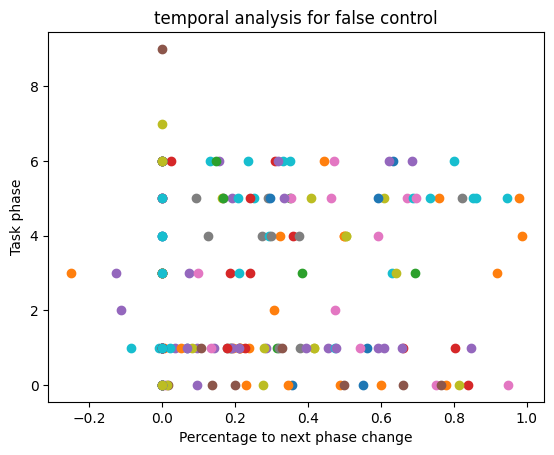

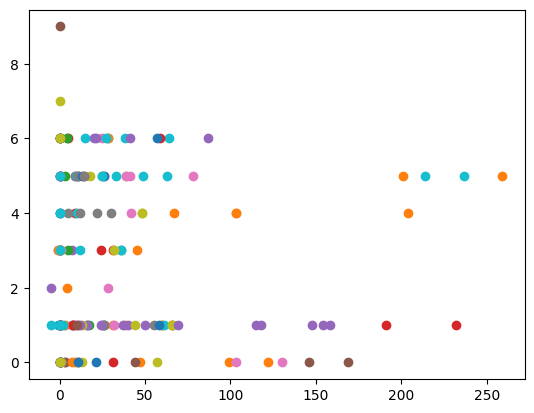

In [14]:
# plot all the percentage to phase change, x is percentage, y is user_id
def plot_percentage_to_phase_change(percentage_list,phase_change_index_i, plt_tiltle="temporal analysis for false control"):
    percentage_30_percent = 0
    percentage_back_50_percent = 0
    all = 0
    for user_id, percentage in percentage_list.items():
        percentage = np.array(percentage)
        percentage_30_percent += len(percentage[percentage <= 0.3])
        percentage_back_50_percent += len(percentage[percentage > 0.5])
        all += len(percentage)
        plt.plot(percentage, phase_change_index_i[user_id], 'o')
    print(percentage_30_percent / all)
    print(percentage_back_50_percent / all)
    plt.title(plt_tiltle)
    plt.xlabel('Percentage to next phase change')
    plt.ylabel('Task phase')
    plt.show()

def plot_steps_to_phase_change(phase_change_steps):
    
    for user_id, steps in phase_change_steps.items():
        plt.plot(steps, phase_change_index[user_id], 'o')
    plt.show()




plot_percentage_to_phase_change(percentage_list, phase_change_index)
plot_steps_to_phase_change(phase_change_steps)

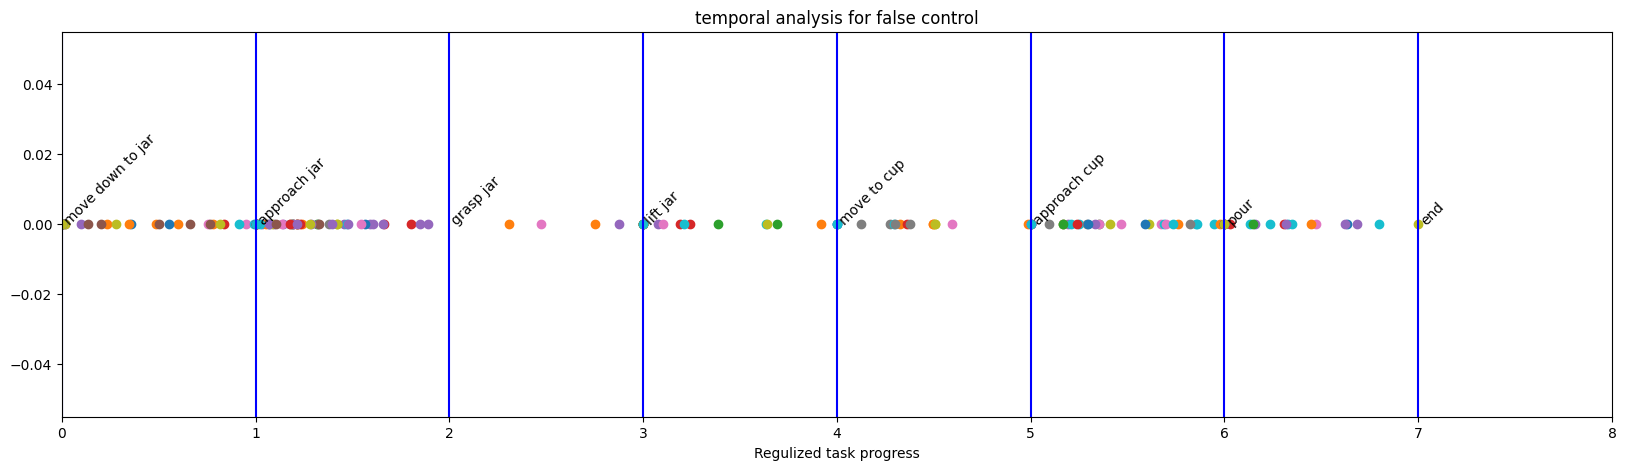

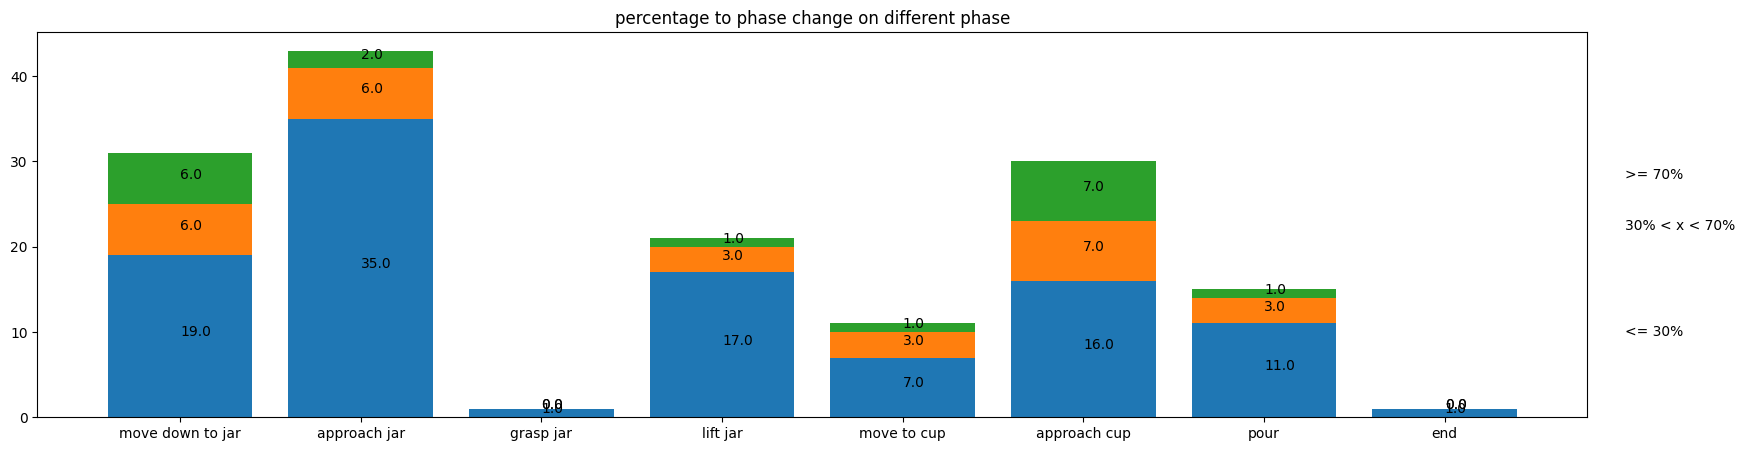

In [15]:
def plot_percentage_with_phase(percentage_list, phase_change_index_i,plt_tilte="temporal analysis for false control"):
    plt.figure(figsize=(20,5))
    ax = plt.gca()
    ax.set_xlim([0,8])
    for user_id, percentage in percentage_list.items():
        percentage_single = np.array(percentage)
        # print(percentage_single)
        phase_index = np.array(phase_change_index_i[user_id])
        plt.plot(percentage_single + phase_index, np.zeros_like(percentage_single + phase_index), 'o')
    task_phases = ["move down to jar", "approach jar", "grasp jar", "lift jar", "move to cup", "approach cup", "pour", "end"]
    
    for i in range(8):
        plt.axvline(x=i,color='b')
        plt.text(i,0,task_phases[i],rotation=45)
    plt.title(plt_tilte)
    plt.xlabel('Regulized task progress')
    plt.show()


def plot_bar_for_percentage_to_phase_change(percentage_list, phase_change_index, plot_title="percentage to phase change on different phase"):
    # stretch x axis longer
    plt.figure(figsize=(20,5))

    all = 0
    percentage_30_percent_per_phase = np.zeros(8)
    percentage_greater_30_percent_less_70_percent_per_phase = np.zeros(8)
    percentage_greater_70_percent_per_phase = np.zeros(8)
    for user_id, percentage in percentage_list.items():
        percentage = np.array(percentage)
        phase_index = np.array(phase_change_index[user_id])
        # count percentafe <= 30% for each phase
        for i in range(8):
            percentage_30_percent_per_phase[i] += len(percentage[(percentage <= 0.3) & (phase_index == i)])
            percentage_greater_30_percent_less_70_percent_per_phase[i] += len(percentage[(percentage > 0.5) &(percentage < 0.8) & (phase_index == i)])
            percentage_greater_70_percent_per_phase[i] += len(percentage[(percentage >= 0.7) & (phase_index == i)])
    # plot the bar, x is phase, y is percentage
    plt.bar(range(8), percentage_30_percent_per_phase)
    plt.bar(range(8), percentage_greater_30_percent_less_70_percent_per_phase, bottom=percentage_30_percent_per_phase)
    plt.bar(range(8), percentage_greater_70_percent_per_phase, bottom=percentage_30_percent_per_phase + percentage_greater_30_percent_less_70_percent_per_phase)

    task_phases = ["move down to jar", "approach jar", "grasp jar", "lift jar", "move to cup", "approach cup", "pour", "end"]
    # add text to the bar
    for i in range(8):
        plt.text(i,percentage_30_percent_per_phase[i]/2,percentage_30_percent_per_phase[i])
        plt.text(i,percentage_30_percent_per_phase[i] + percentage_greater_30_percent_less_70_percent_per_phase[i]/2,percentage_greater_30_percent_less_70_percent_per_phase[i])
        plt.text(i,percentage_30_percent_per_phase[i] + percentage_greater_30_percent_less_70_percent_per_phase[i] + percentage_greater_70_percent_per_phase[i]/2,percentage_greater_70_percent_per_phase[i])
    plt.xticks(range(8), task_phases)
    # add labels for different percentage range
    plt.text(8,percentage_30_percent_per_phase[0]/2,"<= 30%")
    plt.text(8,percentage_30_percent_per_phase[0] + percentage_greater_30_percent_less_70_percent_per_phase[0]/2,"30% < x < 70%")
    plt.text(8,percentage_30_percent_per_phase[0] + percentage_greater_30_percent_less_70_percent_per_phase[0] + percentage_greater_70_percent_per_phase[0]/2,">= 70%")
    plt.title(plot_title)
    plt.show()

plot_percentage_with_phase(percentage_list, phase_change_index)
plot_bar_for_percentage_to_phase_change(percentage_list, phase_change_index)

99.0
29.0
53.0
percentage of across phase change:  0.5469613259668509


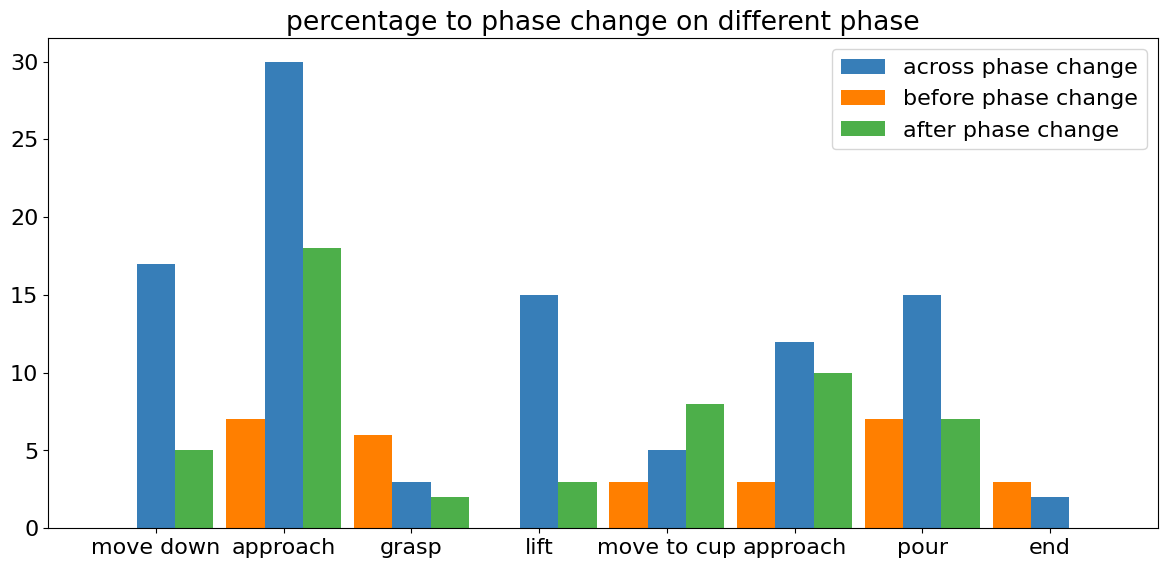

In [16]:
def plot_before_and_after_percentage(percentage_list, phase_change_index, plot_title="percentage to phase change on different phase"):
    '''
    plot new bar chart, three bars for each phase, before 30%, between 30% and 70%, after 70%
    '''
    CB_color_cycle = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']
# Set the font size to match IEEE standard
    plt.rcParams.update({'font.size': 16, 'axes.labelsize': 16, 'legend.fontsize': 16, 'xtick.labelsize': 16, 'ytick.labelsize': 16, 
                         'axes.prop_cycle': plt.cycler(color = CB_color_cycle)})

    # Width and height for a double-column figure in IEEE format
    fig_width = 7.16*2   # width in inches
    fig_height = (fig_width / 36) * 8 *2# height in inches to maintain 9:6 ratio for each subplot
    plt.figure(figsize=(fig_width, fig_height))

    percentage_across_phase_change = np.zeros(8)
    percentage_before_phase_change = np.zeros(8)
    percentage_after_phase_change = np.zeros(8)
    for user_id, percentage in percentage_list.items():
        percentage = np.array(percentage)
        phase_index = np.array(phase_change_index[user_id])
        # count percentafe <= 30% for each phase
        for i in range(8):
            percentage_across_phase_change[i] += len(percentage[(percentage < 0.2) & (phase_index == i)])
            percentage_across_phase_change[i] += len(percentage[(percentage >= 0.8) & (phase_index == i-1)])
            percentage_before_phase_change[i] += len(percentage[(percentage >= 0.5) &(percentage < 0.8) & (phase_index == i-1)])
            percentage_after_phase_change[i] += len(percentage[(percentage >= 0.2) & (percentage < 0.5) & (phase_index == i)])
    
    percentage_across_phase_change_sum = percentage_across_phase_change.sum()
    percentage_before_phase_change_sum = percentage_before_phase_change.sum()
    percentage_after_phase_change_sum = percentage_after_phase_change.sum()

    total = percentage_across_phase_change_sum + percentage_before_phase_change_sum + percentage_after_phase_change_sum
    total_percentage_of_across = percentage_across_phase_change_sum / total
    print(percentage_across_phase_change_sum)
    print(percentage_before_phase_change_sum)
    print(percentage_after_phase_change_sum)
    print("percentage of across phase change: ", total_percentage_of_across,)

    # plt.figure(figsize=(20,12))
    # plot three bars, one beside another for each phase
    plt.bar(range(8), percentage_across_phase_change, width=0.3)
    plt.bar(np.array(range(8)) - 0.3, percentage_before_phase_change, width=0.3)
    plt.bar(np.array(range(8)) + 0.3, percentage_after_phase_change, width=0.3)



    task_phases = ["move down", "approach", "grasp", "lift", "move to cup", "approach", "pour", "end"]
    # add text to the bar
    plt.xticks(range(8), task_phases)
    # plt.yticks(fontsize=20)

    # add legend
    plt.legend(["across phase change", "before phase change", "after phase change"])
    
    
    plt.title(plot_title)
    plt.show()

plot_before_and_after_percentage(percentage_list, phase_change_index)

user_30 333 343 343
user_10 244 244 244
user_24 2 3 3
user_30 340 343 343
[]
[]
[ 99   0 204]
[0 3 4]
[17]
[1]
[]
[]
[7 1]
[3 5]
[ 3 11  0]
[0 0 9]
[103   0]
[0 5]
[22]
[4]
[]
[]
[237  64]
[5 6]
[0 0]
[0 4]
[ 0  9 45]
[0 0 3]
[0 0]
[0 3]
[31 66 24 31]
[0 1 3 3]
[  0   9  25 158  -1]
[1 1 1 1 3]
[26]
[1]
[42 25]
[4 6]
[]
[]
[0 0 0]
[0 3 7]
[ 0  0 12 10  0]
[0 3 3 4 6]
[0]
[4]
[4]
[2]
[ 0 16  0  0]
[0 1 3 6]
[0]
[3]
[-5 41 21]
[2 6 6]
[ 44 146]
[0 0]
[ 0  0  0 26 39]
[0 3 5 5 5]
[]
[]
[ 1 13]
[0 1]
[]
[]
[11  0]
[0 6]
[-1 28]
[3 6]
[5 4]
[3 6]
[0]
[6]
[  0  12  37 115]
[0 1 1 1]
[0]
[5]
[1]
[3]
[ 5 12  0]
[4 4 6]
[0 0 0]
[0 3 6]
[-5  0  0]
[1 3 4]
48.0
0.0
33.0
percentage of across phase change:  0.5925925925925926


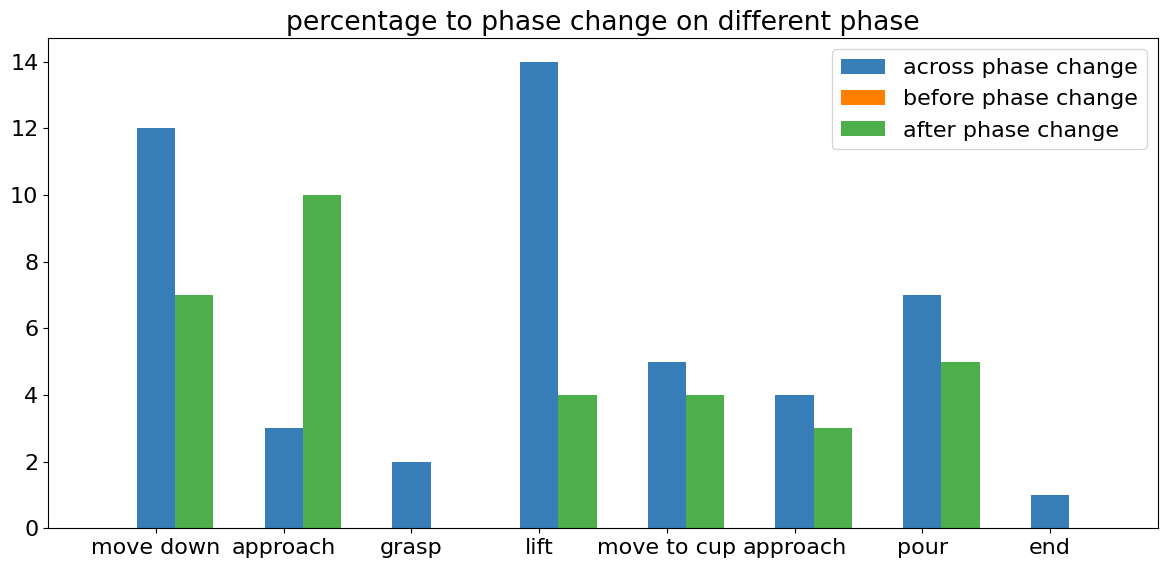

[0 0 7]
[0 4 5]
[ -1  14  23  29   5  67 136 155   0  14  34  46  60  91 105 114 150 180
 200 235 252   0  67  88 103 127 137 155 205]
[0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 3 4 4 4 4 4 4 4]
[-4  0 34 62]
[2 3 5 5]
[-1]
[3]
[-1 18  0 -1  1]
[1 1 3 4 5]
[27 11 -1]
[1 4 7]
[ 89 131  67  -1   0]
[0 0 1 2 5]
[-8 -4  1 33]
[2 3 6 6]
[34 52 -7  0 59 39 48 42 49]
[1 1 2 3 4 5 5 6 6]
[ 17  -1   0  12  32  12  58  73  96 138 173   0  71]
[1 2 3 3 3 5 5 5 5 5 5 6 6]
[ 0  0 -1 23 23 54 18]
[0 1 3 3 4 4 5]
[ -1  29  40  92 259  17]
[3 3 3 5 5 6]
[ 0  0 -8 -1 35 39 14]
[0 1 2 3 3 4 5]
[  0  24  55 173 191 203 231  -5  20  30  53  71  87  -1  41  35  58 102
 120 129 139]
[0 1 1 1 1 1 1 3 3 3 3 3 3 5 5 6 6 6 6 6 6]
[ -1  50  94 154 177 194  -3   0  25  38   0  18  50  58  68  81 101 117
 125]
[0 1 1 1 1 1 2 3 5 5 6 6 6 6 6 6 6 6 6]
[ 0 22 -1 14 57]
[0 0 1 1 1]
[ 0  8 14 40 95]
[4 4 4 5 5]
[  0  84 -29   0  21  59]
[0 1 2 2 5 5]
[ 0  0  0  8 39  0]
[0 1 3 3 5 6]
[ 0 -7 -1 43]
[0 2 3 5]
[  0 -27  -

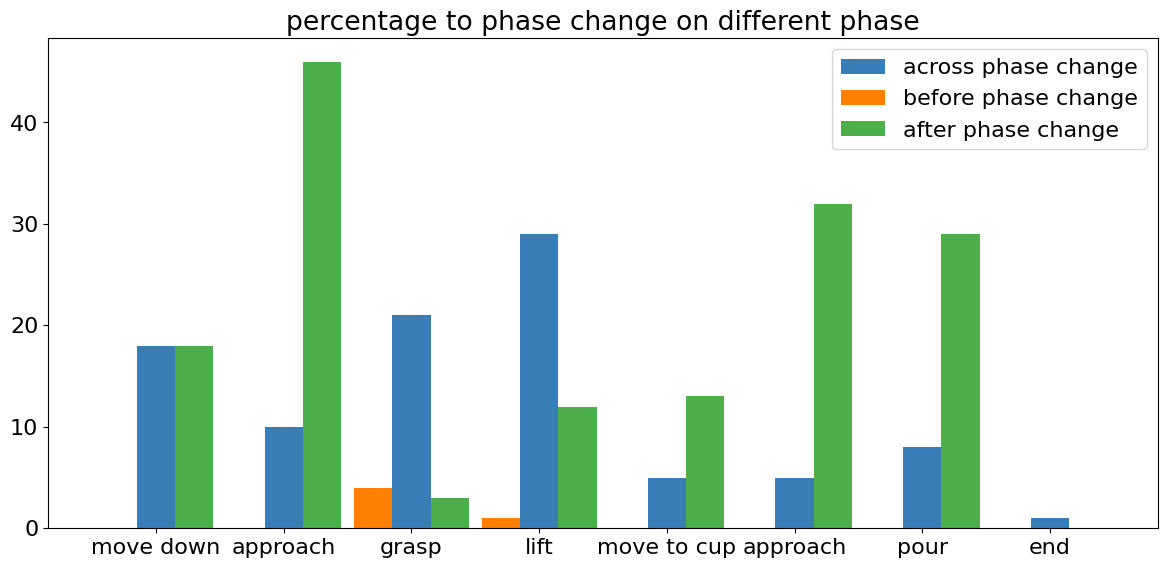

In [17]:
def plot_before_and_after_steps(steps_list,all_task_phase_change, phase_change_index, plot_title="percentage to phase change on different phase"):
    '''
    plot new bar chart, three bars for each phase, before 30%, between 30% and 70%, after 70%
    '''
    CB_color_cycle = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']
# Set the font size to match IEEE standard
    plt.rcParams.update({'font.size': 16, 'axes.labelsize': 16, 'legend.fontsize': 16, 'xtick.labelsize': 16, 'ytick.labelsize': 16, 
                         'axes.prop_cycle': plt.cycler(color = CB_color_cycle)})

    # Width and height for a double-column figure in IEEE format
    fig_width = 7.16*2   # width in inches
    fig_height = (fig_width / 36) * 8 *2# height in inches to maintain 9:6 ratio for each subplot
    plt.figure(figsize=(fig_width, fig_height))

    percentage_across_phase_change = np.zeros(8)
    percentage_before_phase_change = np.zeros(8)
    percentage_after_phase_change = np.zeros(8)
    for user_id, percentage in steps_list.items():
        task_phase_change_single = all_task_phase_change[user_id] 
        phase_length = np.diff(task_phase_change_single)
        percentage = np.array(percentage)
        phase_index = np.array(phase_change_index[user_id])
        # count percentafe <= 30% for each phase
        print(percentage)
        print(phase_index)
        for i in range(8):
            percentage_across_phase_change[i] += len(percentage[(percentage <= 10) &(percentage >= -10)& (phase_index == i)])
            # percentage_across_phase_change[i] += len(percentage[(percentage >= 0.8) & (phase_index == i-1)])
            percentage_before_phase_change[i] += len(percentage[(percentage <-10) & (phase_index == i)])
            percentage_after_phase_change[i] += len(percentage[(percentage >10) & (phase_index == i)])
    
    percentage_across_phase_change_sum = percentage_across_phase_change.sum()
    percentage_before_phase_change_sum = percentage_before_phase_change.sum()
    percentage_after_phase_change_sum = percentage_after_phase_change.sum()

    total = percentage_across_phase_change_sum + percentage_before_phase_change_sum + percentage_after_phase_change_sum
    total_percentage_of_across = percentage_across_phase_change_sum / total
    print(percentage_across_phase_change_sum)
    print(percentage_before_phase_change_sum)
    print(percentage_after_phase_change_sum)
    print("percentage of across phase change: ", total_percentage_of_across,)

    # plt.figure(figsize=(20,12))
    # plot three bars, one beside another for each phase
    plt.bar(range(8), percentage_across_phase_change, width=0.3)
    plt.bar(np.array(range(8)) - 0.3, percentage_before_phase_change, width=0.3)
    plt.bar(np.array(range(8)) + 0.3, percentage_after_phase_change, width=0.3)



    task_phases = ["move down", "approach", "grasp", "lift", "move to cup", "approach", "pour", "end"]
    # add text to the bar
    plt.xticks(range(8), task_phases)
    # plt.yticks(fontsize=20)

    # add legend
    plt.legend(["across phase change", "before phase change", "after phase change"])
    
    
    plt.title(plot_title)
    plt.show()


_,false_action_idx,false_actions_change_steps = calculate_percentage_to_phase_change(all_task_phase_change, false_actions, eef_poses)
_,pauses_idx,pauses_change_steps = calculate_percentage_to_phase_change(all_task_phase_change, pauses, eef_poses)
plot_before_and_after_steps(false_actions_change_steps,all_task_phase_change, false_action_idx)
plot_before_and_after_steps(pauses_change_steps,all_task_phase_change, pauses_idx)

In [18]:
def plot_seconds_within_change(steps_list,all_task_phase_change, phase_change_index, plot_title="percentage to phase change on different phase"):
    '''
    plot new bar chart, three bars for each phase, before 30%, between 30% and 70%, after 70%
    '''
    CB_color_cycle = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']
# Set the font size to match IEEE standard
    plt.rcParams.update({'font.size': 16, 'axes.labelsize': 16, 'legend.fontsize': 16, 'xtick.labelsize': 16, 'ytick.labelsize': 16, 
                         'axes.prop_cycle': plt.cycler(color = CB_color_cycle)})

    # Width and height for a double-column figure in IEEE format
    fig_width = 7.16*2   # width in inches
    fig_height = (fig_width / 36) * 8 *2# height in inches to maintain 9:6 ratio for each subplot
    plt.figure(figsize=(fig_width, fig_height))

    percentage_across_phase_change = np.zeros(8)
    percentage_before_phase_change = np.zeros(8)
    percentage_after_phase_change = np.zeros(8)
    for user_id, percentage in steps_list.items():
        task_phase_change_single = all_task_phase_change[user_id] 
        phase_length = np.diff(task_phase_change_single)
        percentage = np.array(percentage)
        phase_index = np.array(phase_change_index[user_id])
        # count percentafe <= 30% for each phase
        print(percentage)
        print(phase_index)
        for i in range(8):
            percentage_across_phase_change[i] += len(percentage[(percentage <= 10) &(percentage >= -10)& (phase_index == i)])
            # percentage_across_phase_change[i] += len(percentage[(percentage >= 0.8) & (phase_index == i-1)])
            percentage_before_phase_change[i] += len(percentage[(percentage <-10) & (phase_index == i)])
            percentage_after_phase_change[i] += len(percentage[(percentage >10) & (phase_index == i)])
    
    percentage_across_phase_change_sum = percentage_across_phase_change.sum()
    percentage_before_phase_change_sum = percentage_before_phase_change.sum()
    percentage_after_phase_change_sum = percentage_after_phase_change.sum()

    total = percentage_across_phase_change_sum + percentage_before_phase_change_sum + percentage_after_phase_change_sum
    total_percentage_of_across = percentage_across_phase_change_sum / total
    print(percentage_across_phase_change_sum)
    print(percentage_before_phase_change_sum)
    print(percentage_after_phase_change_sum)
    print("percentage of across phase change: ", total_percentage_of_across,)

    # plt.figure(figsize=(20,12))
    # plot three bars, one beside another for each phase
    plt.bar(range(8), percentage_across_phase_change, width=0.3)
    plt.bar(np.array(range(8)) - 0.3, percentage_before_phase_change, width=0.3)
    plt.bar(np.array(range(8)) + 0.3, percentage_after_phase_change, width=0.3)



    task_phases = ["move down", "approach", "grasp", "lift", "move to cup", "approach", "pour", "end"]
    # add text to the bar
    plt.xticks(range(8), task_phases)
    # plt.yticks(fontsize=20)

    # add legend
    plt.legend(["across phase change", "before phase change", "after phase change"])
    
    
    plt.title(plot_title)
    plt.show()

In [19]:
def get_all_alignment_actions(annotation_data):
    # read every list of dictionary in the json file, store step if annotation key is  "task phase change"
    all_alignment_actions = dict()
    for user_id, annotation_data_single in annotation_data.items():
        alignment_actions = []
        for annotation in annotation_data_single:
            if annotation['annotation'] == "alignment":
                alignment_actions.append([annotation["action_step_start"], annotation["action_step_end"]])
        all_alignment_actions[user_id] = alignment_actions
    return all_alignment_actions

def get_all_grasp_indicies(task_phase_change_dict):
    all_grasp_actions = dict()
    for user_id, annotation_data_single in task_phase_change_dict.items():
        grasp_actions = []
        for annotation in annotation_data_single:
            if annotation['annotation'] == "task phase change" and "grasp" in annotation["actions_after_this_behavior"]:
                grasp_actions.append(annotation["step"])
        all_grasp_actions[user_id] = grasp_actions
    return all_grasp_actions

user_30 333 343 343
user_30 333 343 343
user_30 333 343 343
user_30 333 343 343
user_30 333 343 343
user_30 333 343 343
user_30 333 343 343
user_10 244 244 244
user_10 244 244 244
user_10 244 244 244
user_24 2 3 3


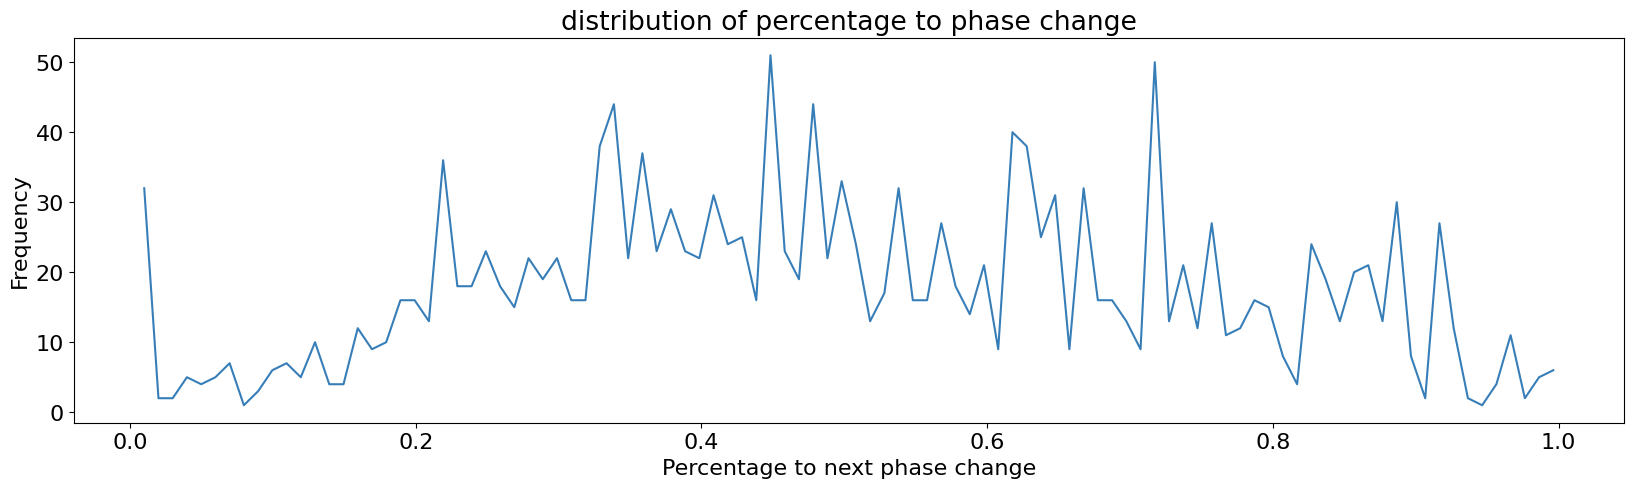

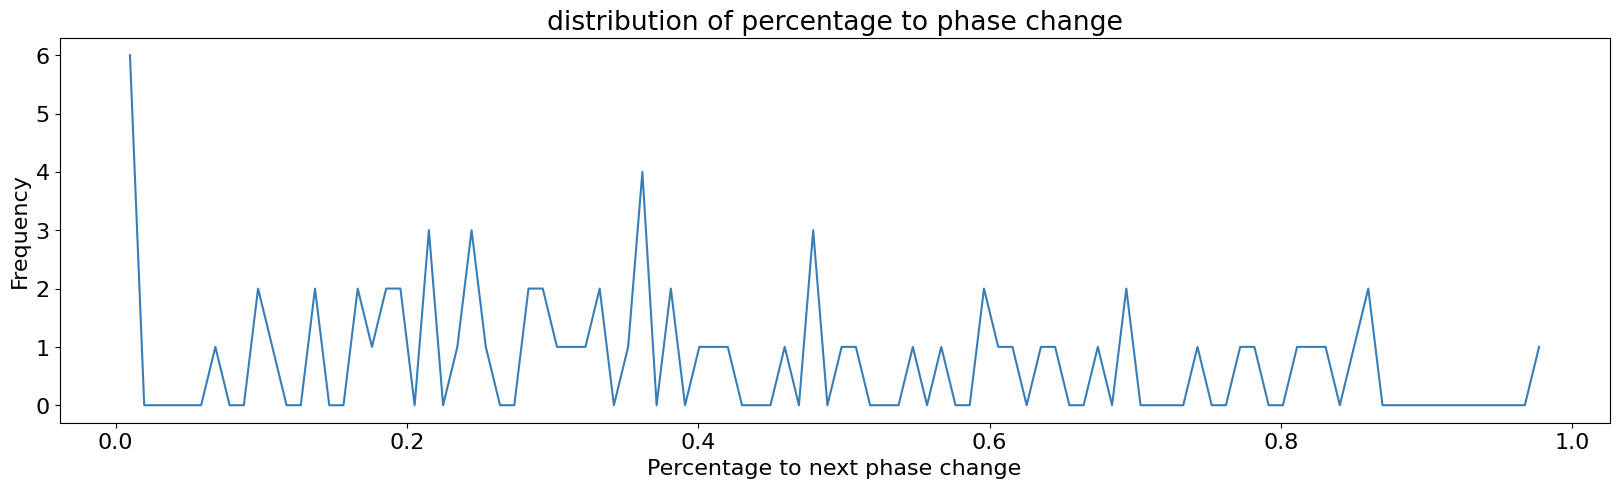

user_27 14 15 15
user_30 340 343 343
user_30 340 343 343
user_30 340 343 343
user_30 340 343 343
user_30 340 343 343
user_30 340 343 343
user_30 340 343 343
user_30 340 343 343
user_30 340 343 343
user_27 14 15 15
user_32 16 17 17
user_30 333 343 343
user_10 244 244 244
user_24 2 3 3
155
523
0
64
124
60
44
skipped
skipped
skipped
skipped
skipped
skipped
skipped
skipped
skipped
skipped
skipped
skipped
skipped
skipped
skipped
skipped
skipped
skipped
skipped
skipped
328
568
454
670
262
342
281
187
595
4
9
180
492
300
skipped
skipped
skipped
skipped
skipped
skipped
skipped
skipped
skipped
skipped
skipped
236
206
10
211
84
70
143
skipped
skipped
32
53
3
22
16
33
21


<Figure size 2000x500 with 0 Axes>

<Figure size 2000x500 with 0 Axes>

<Figure size 2000x500 with 0 Axes>

<Figure size 2000x500 with 0 Axes>

<Figure size 2000x500 with 0 Axes>

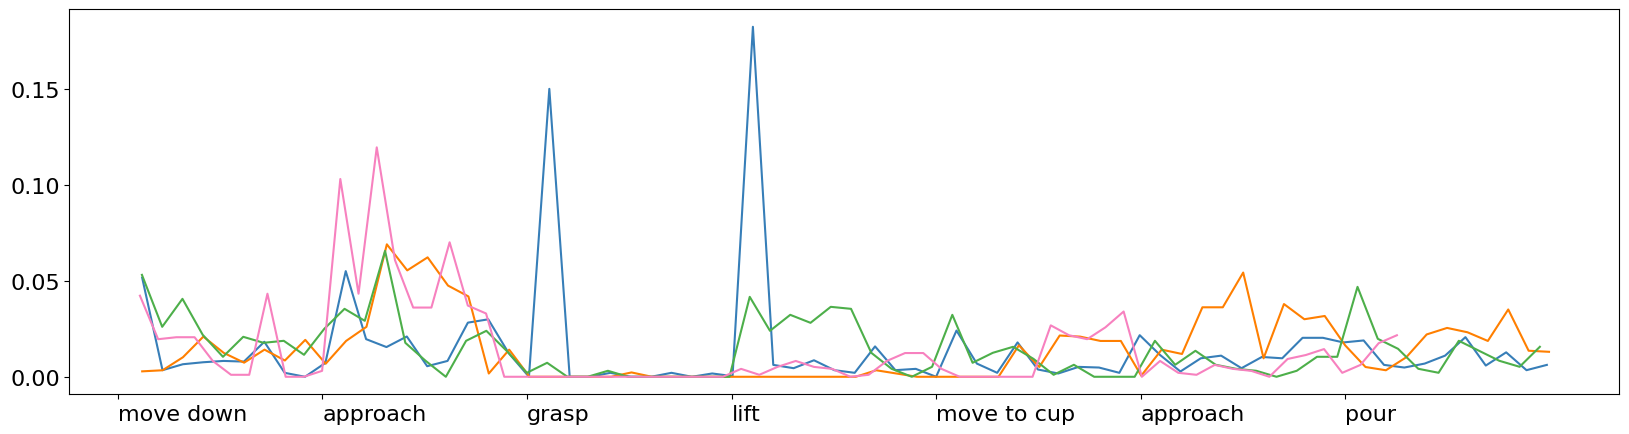

In [20]:

def calculate_percentage_to_phase_change_each_step(all_task_phase_change, false_actions, eef_poses_dict):
    percentage_to_phase_change = dict()
    closest_phase_change_index = dict()
    steps_to_phase_change = dict()
    for user_id, task_phase_change in all_task_phase_change.items():
        user_eef_poses = eef_poses_dict[user_id]
        task_phase_change = np.array(task_phase_change)
        percentage_to_phase_change[user_id] = []
        closest_phase_change_index[user_id] = []
        steps_to_phase_change[user_id] = []
        for action in false_actions[user_id]:
            # find the closest previous task phase change
            # for act in action:
            for act in range(action[0], action[1]):
            # act = action[0]
            
                # clear pause steps
                act = clear_pause_steps(user_eef_poses, act, action[1])

                # ignore all actions after task end
                if act > task_phase_change[-1]:
                    continue
                closest_phase_change = task_phase_change[task_phase_change <= act]
                if len(closest_phase_change) == 0:
                    closest_phase_change = 0
                    closest_phase_change_index[user_id].append(0)
                else:
                    closest_phase_change = closest_phase_change.max()
                    # get the index of the closest phase change
                    closest_phase_change_idx_single = np.where(task_phase_change == closest_phase_change)[0][0]
                    closest_phase_change_index[user_id].append(closest_phase_change_idx_single)
                # calculate the percentage of action from closest task phase change to next task phase change
                # if there is no next task phase change, calculate the percentage to the end of the task
                # if there is no previous task phase change, calculate the percentage to the start of the task
                
                next_phase_change = task_phase_change[task_phase_change > act]
                
                if len(next_phase_change) == 0:
                    next_phase_change = task_phase_change.max()
                else:
                    next_phase_change = next_phase_change.min()
                
                # next_phase_change = clear_pause_steps(user_eef_poses, next_phase_change, task_phase_change+10)
                # clear phase change steps
                # print(closest_phase_change, next_phase_change, task_phase_change.max()-1)
                closest_phase_change = clear_pause_steps(user_eef_poses, closest_phase_change, min(next_phase_change, task_phase_change.max()))
                next_phase_change_index = np.where(task_phase_change == next_phase_change)[0][0]
                next_phase_change = clear_pause_steps(user_eef_poses, next_phase_change, task_phase_change[min(next_phase_change_index+1, len(task_phase_change)-1)])
                if next_phase_change == closest_phase_change:
                    print(user_id, act, closest_phase_change, next_phase_change)
                    percentage = 0
                    steps = 0
                else:
                    percentage = (act - closest_phase_change)/(next_phase_change - closest_phase_change)
                    steps = (act - closest_phase_change)
                

                # percentage can be smaller than 0 due to clear_pause_steps, make it 0
                if percentage < 0:
                    percentage = 0
                percentage_to_phase_change[user_id].append(percentage)
                steps_to_phase_change[user_id].append(steps)
            
            # calculate the percentage to the closest task phase change
            # measured by dist from 
    return percentage_to_phase_change, closest_phase_change_index, steps_to_phase_change


# plot the distribution of percentage to phase change

def plot_distribution_of_percentage_to_phase_change(percentage_list, phase_change_index, plot_title="distribution of percentage to phase change"):
    plt.figure(figsize=(20,5))
    percentage_all = [percentage for user_id, percentage in percentage_list.items()]
    percentage_all = np.concatenate(percentage_all)
    # fiter all the 
    y = np.histogram(percentage_all, bins=100)
    # add some smoothing
    # y = [y[0], np.convolve(y[1], np.ones(5)/5, mode='same')]
    plt.plot(y[1][1:], y[0])

    plt.title(plot_title)
    plt.xlabel('Percentage to next phase change')
    plt.ylabel('Frequency')
    plt.show()

def plot_distribution_of_percentage_to_phase_change_with_subtasks(percentage_list, phase_change_index, plot_title="distribution of steps to phase change"):
    percentage_with_task = {
            0: [],
            1: [],
            2: [],
            3: [],
            4: [],
            5: [],
            6: [],
        }
    for user_id in percentage_list.keys():
        percetage_single = percentage_list[user_id]
        # print(len(percetage_single))
        phase_change_index_single = phase_change_index[user_id]
        
        for i in range(len(percetage_single)):
            if phase_change_index_single[i] > 6:
                print("skipped")
                continue
            percentage_with_task[phase_change_index_single[i]].append(percetage_single[i])
    plt.figure(figsize=(20,5))
    final_data_x = []
    final_data_y = []
    for i in range(7):
        print(len(percentage_with_task[i]))
        y = np.histogram(percentage_with_task[i], bins=50)
        # draw bar chart
        final_data_x.extend(y[1][1:] + i)
        final_data_y.extend(y[0])
        # plt.plot(y[1][1:] + i, y[0])
    # plot bar chart    
    # plt.hist(final_data_x, bins=50, weights=final_data_y, edgecolor='black', linewidth=1.2, color='skyblue')
    # plot hist as line chart
    y = np.histogram(final_data_x, bins=70, weights=final_data_y)
    return y
    # plt.plot(y[1][1:], y[0])
    # plt.plot(final_data_x, final_data_y)
    
        

percentage_list_every_step_false_actions,phase_change_index_every_step_false_actions,_ = calculate_percentage_to_phase_change_each_step(all_task_phase_change, false_actions,eef_poses)
# plot_distribution_of_percentage_to_phase_change(percentage_list_every_step_false_actions, phase_change_index_every_step_false_actions)
# plot_distribution_of_percentage_to_phase_change(percentage_list, phase_change_index)


alignment_dict = get_all_alignment_actions(annotation_data)
grasp_indicies = get_all_grasp_indicies(annotation_data)
# test_controller = get



percentage_list_evert_step_alignment,phase_change_index_every_step_alignment,_ = calculate_percentage_to_phase_change_each_step(all_task_phase_change, alignment_dict,eef_poses)
alignment_start_percentage, alignment_start_phase,_ = calculate_percentage_to_phase_change(all_task_phase_change, alignment_dict,eef_poses)
plot_distribution_of_percentage_to_phase_change(percentage_list_evert_step_alignment, phase_change_index_every_step_alignment)
plot_distribution_of_percentage_to_phase_change(alignment_start_percentage, alignment_start_phase)


test_con_ev, phase_idx_test_con,_ = calculate_percentage_to_phase_change_each_step(all_task_phase_change, test_controller_actions,eef_poses)
pause_ev, phase_idx_pauses,_ = calculate_percentage_to_phase_change_each_step(all_task_phase_change, pauses,eef_poses)


all_action_ev, phase_idx_all ,_= calculate_percentage_to_phase_change(all_task_phase_change, all_actions, eef_poses)

y_test_con = plot_distribution_of_percentage_to_phase_change_with_subtasks(test_con_ev, phase_idx_test_con)
y_pauses = plot_distribution_of_percentage_to_phase_change_with_subtasks(pause_ev, phase_idx_pauses)
y_alignment = plot_distribution_of_percentage_to_phase_change_with_subtasks(percentage_list_evert_step_alignment, phase_change_index_every_step_alignment)
y_false_actions = plot_distribution_of_percentage_to_phase_change_with_subtasks(percentage_list_every_step_false_actions, phase_change_index_every_step_false_actions)
y_all = plot_distribution_of_percentage_to_phase_change_with_subtasks(all_action_ev,phase_idx_all )



plt.figure(figsize=(20,5))
# plt.plot(x_pauses,y_pauses)
# plt.plot(x_alignment, y_alignment)
# plt.plot(x_false_actions, y_false_actions)
# plt.plot(y_test_con, y_test_con)
plt.plot(y_pauses[1][1:], y_pauses[0] / sum(y_pauses[0]))
plt.plot(y_alignment[1][1:], y_alignment[0]/ sum(y_alignment[0]))
plt.plot(y_false_actions[1][1:], y_false_actions[0]/ sum(y_false_actions[0]))
plt.plot(y_test_con[1][1:], y_test_con[0]/sum(y_test_con[0]))
x_labels = ["move down", "approach", "grasp", "lift", "move to cup", "approach", "pour"]
plt.xticks(range(7), x_labels)


# ax2 = ax1.twinx()  # Create secondary y-axis (right side)

# # Plot the `y_pauses` on the secondary y-axis
# ax2.plot(y_pauses[1][1:], y_pauses[0], label="Pauses", color="red")
# ax2.set_ylabel("Pauses", color="red")  # Label for the secondary y-axis
# ax2.tick_params(axis='y', labelcolor='red')



# ax = plt.gca()  # Get current axis
# xticks = ax.get_xticks()

ax = plt.gca()

# Adjust only the label positions without moving the ticks
for tick, label in zip(ax.get_xticks(), ax.get_xticklabels()):
    label.set_horizontalalignment('left')  # Align left
    # label.set_x(tick + 5000)  # Shift the label 0.5 units to the right


# print(xticks)

# for i, label in enumerate(ax.get_xticklabels()):
#     print(label)
#     label.set_x(xticks[i] + 0.5)
# label in the middle
# plt.xticks(np.array(range(7))+0.5, x_labels)
plt.show()

# y_test_con

user_30 333 343 343
user_10 244 244 244
user_24 2 3 3
user_30 340 343 343
[]
[]
[ 60 103]
[1 4]
[]
[]
[]
[]
[11]
[1]
[]
[]
[  1 130]
[0 0]
[]
[]
[]
[]
[]
[]
[]
[]
[  1 201]
[1 5]
[36]
[3]
[  0   0 191   5]
[0 1 1 6]
[50]
[1]
[]
[]
[]
[]
[]
[]
[]
[]
[-1 36]
[1 3]
[0]
[3]
[3]
[1]
[]
[]
[0]
[1]
[16 11]
[1 5]
[1]
[0]
[]
[]
[]
[]
[66 48]
[1 4]
[2]
[1]
[0]
[0]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[0 0]
[1 5]
percentage of across phase change:  0.5185185185185185
[0 0 7]
[0 4 5]
[ -1  14  23  29   5  67 136 155   0  14  34  46  60  91 105 114 150 180
 200 235 252   0  67  88 103 127 137 155 205]
[0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 3 4 4 4 4 4 4 4]
[-4  0 34 62]
[2 3 5 5]
[-1]
[3]
[-1 18  0 -1  1]
[1 1 3 4 5]
[27 11 -1]
[1 4 7]
[ 89 131  67  -1   0]
[0 0 1 2 5]
[-8 -4  1 33]
[2 3 6 6]
[34 52 -7  0 59 39 48 42 49]
[1 1 2 3 4 5 5 6 6]
[ 17  -1   0  12  32  12  58  73  96 138 173   0  71]
[1 2 3 3 3 5 5 5 5 5 5 6 6]
[ 0  0 -1 23 23 54 18]
[0 1 3 3 4 4 5]
[ -1  29  40  92 259  17

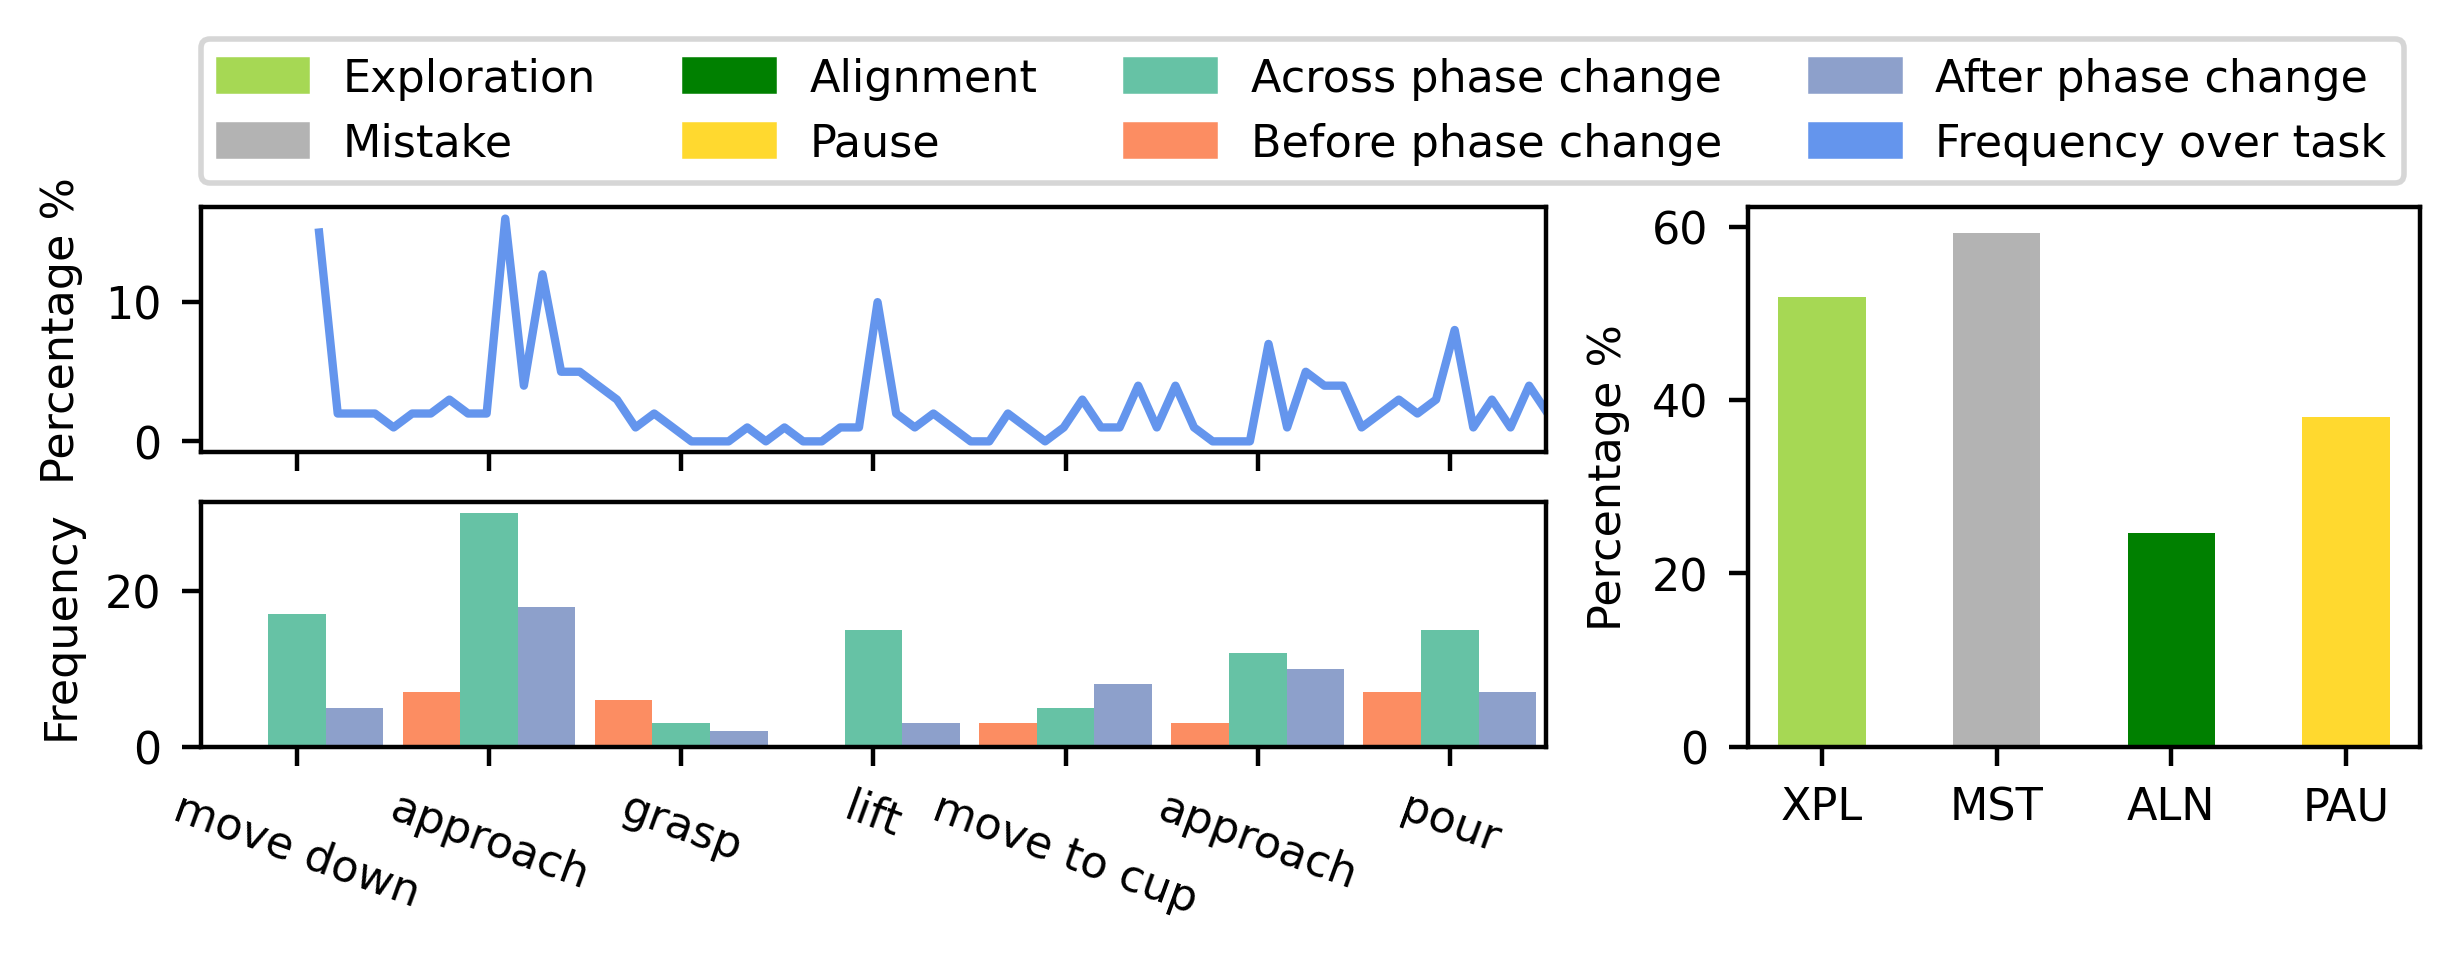

In [21]:
from matplotlib.gridspec import GridSpec
import matplotlib.patches as mpatches
from matplotlib.ticker import PercentFormatter

def get_before_and_after_percentage_new(percentage_list, 
                                     phase_change_index, 
                                     plot_title="percentage to phase change on different phase"):
    '''
    plot new bar chart, three bars for each phase, before 30%, between 30% and 70%, after 70%
    '''    

    percentage_across_phase_change = np.zeros(8)
    percentage_before_phase_change = np.zeros(8)
    percentage_after_phase_change = np.zeros(8)
    for user_id, percentage in percentage_list.items():
        percentage = np.array(percentage)
        phase_index = np.array(phase_change_index[user_id])
        # count percentafe <= 30% for each phase
        for i in range(8):
            percentage_across_phase_change[i] += len(percentage[(percentage < 0.2) & (phase_index == i)])
            percentage_across_phase_change[i] += len(percentage[(percentage >= 0.8) & (phase_index == i-1)])
            percentage_before_phase_change[i] += len(percentage[(percentage >= 0.5) &(percentage < 0.8) & (phase_index == i-1)])
            percentage_after_phase_change[i] += len(percentage[(percentage >= 0.2) & (percentage < 0.5) & (phase_index == i)])
    
    percentage_across_phase_change_sum = percentage_across_phase_change.sum()
    percentage_before_phase_change_sum = percentage_before_phase_change.sum()
    percentage_after_phase_change_sum = percentage_after_phase_change.sum()

    total = percentage_across_phase_change_sum + percentage_before_phase_change_sum + percentage_after_phase_change_sum
    total_percentage_of_across = percentage_across_phase_change_sum / total
    print(percentage_across_phase_change_sum)
    print(percentage_before_phase_change_sum)
    print(percentage_after_phase_change_sum)
    print("percentage of across phase change: ", total_percentage_of_across,)
    return percentage_across_phase_change, percentage_before_phase_change, percentage_after_phase_change

def get_action_before_and_after_steps(steps_list,all_task_phase_change, phase_change_index):
    percentage_across_phase_change = np.zeros(8)
    percentage_before_phase_change = np.zeros(8)
    percentage_after_phase_change = np.zeros(8)
    for user_id, percentage in steps_list.items():
        task_phase_change_single = all_task_phase_change[user_id] 
        phase_length = np.diff(task_phase_change_single)
        percentage = np.array(percentage)
        phase_index = np.array(phase_change_index[user_id])
        # count percentafe <= 30% for each phase
        print(percentage)
        print(phase_index)
        for i in range(8):
            percentage_across_phase_change[i] += len(percentage[(percentage <= 10) &(percentage >= -10)& (phase_index == i)])
            # percentage_across_phase_change[i] += len(percentage[(percentage >= 0.8) & (phase_index == i-1)])
            percentage_before_phase_change[i] += len(percentage[(percentage <-10) & (phase_index == i)])
            percentage_after_phase_change[i] += len(percentage[(percentage >10) & (phase_index == i)])
    
    percentage_across_phase_change_sum = percentage_across_phase_change.sum()
    percentage_before_phase_change_sum = percentage_before_phase_change.sum()
    percentage_after_phase_change_sum = percentage_after_phase_change.sum()

    total = percentage_across_phase_change_sum + percentage_before_phase_change_sum + percentage_after_phase_change_sum
    total_percentage_of_across = percentage_across_phase_change_sum / total
    # print(percentage_across_phase_change_sum)
    # print(percentage_before_phase_change_sum)
    # print(percentage_after_phase_change_sum)
    print("percentage of across phase change: ", total_percentage_of_across,)
    return percentage_across_phase_change, percentage_before_phase_change, percentage_after_phase_change


_,false_action_idx,false_actions_change_steps = calculate_percentage_to_phase_change(all_task_phase_change, false_actions, eef_poses)
_,pauses_idx,pauses_change_steps = calculate_percentage_to_phase_change(all_task_phase_change, pauses, eef_poses)
_,test_controller_idx,test_controller_change_steps = calculate_percentage_to_phase_change(all_task_phase_change, test_controller_actions, eef_poses)
_,alignment_idx,alignment_change_steps = calculate_percentage_to_phase_change(all_task_phase_change, alignment_dict, eef_poses)


test_controller_across, test_controller_before, test_controller_after = get_action_before_and_after_steps(test_controller_change_steps, all_task_phase_change, test_controller_idx)
pauses_across, pauses_before, pauses_after = get_action_before_and_after_steps(pauses_change_steps, all_task_phase_change, pauses_idx)
false_actions_across, false_actions_before, false_actions_after = get_action_before_and_after_steps(false_actions_change_steps, all_task_phase_change, false_action_idx)
alignment_across, alignment_before, alignment_after = get_action_before_and_after_steps(alignment_change_steps, all_task_phase_change, alignment_idx)


percentage_across, percentage_before, percentage_after = get_before_and_after_percentage_new(percentage_list, phase_change_index)

# percentage_across[-2] += percentage_across[-1]
# percentage_before[-2] += percentage_before[-1]
# percentage_after[-2] += percentage_after[1]

import seaborn as sns
color = sns.color_palette("Set2",n_colors=10)
color[3] = color[6]

plt.rcParams.update({'font.size': 8, 'axes.labelsize': 8, 'legend.fontsize': 8, 'xtick.labelsize': 8, 'ytick.labelsize': 8, 
                         'axes.prop_cycle': plt.cycler(color = color)})

# Width and height for a double-column figure in IEEE format
fig_width = 7.16  # width in inches
fig_height = 2.2*fig_width / 9 # height in inches to maintain 9:6 ratio for each subplot
fig = plt.figure(figsize=(fig_width, fig_height), dpi=400)

gs = GridSpec(2, 2, width_ratios=[2 , 1])

ax1 = fig.add_subplot(gs[1, 0])
ax1.bar(np.array(range(7)), percentage_across[:-1], width=0.3, label="Across phase change")
ax1.bar(np.array(range(7)) - 0.3, percentage_before[:-1], width=0.3, label="Before phase change")
ax1.bar(np.array(range(7)) + 0.3, percentage_after[:-1], width=0.3, label="After phase change")

ax1.set_xticks(np.array(range(7)), ["move down", "approach", "grasp", "lift", "move to cup", "approach", "pour"], rotation=-20)
for label in ax1.get_xticklabels():
    label.set_ha('center')
ax1.set_ylabel("Frequency")
ax2 = fig.add_subplot(gs[:, 1])
test_controller_across_sum = np.sum(test_controller_across)
test_controller_total = test_controller_across_sum + np.sum(test_controller_before) + np.sum(test_controller_after)

pauses_across_sum = np.sum(pauses_across)
pauses_total = pauses_across_sum + np.sum(pauses_before) + np.sum(pauses_after)

false_actions_across_sum = np.sum(false_actions_across)
false_actions_total = false_actions_across_sum + np.sum(false_actions_before) + np.sum(false_actions_after)

alignment_across_sum = np.sum(alignment_across)
alignment_total = alignment_across_sum + np.sum(alignment_before) + np.sum(alignment_after)

ax2.bar(0, test_controller_across_sum / test_controller_total*100, width=0.5, label="Test controller", color=color[4])
ax2.bar(1, false_actions_across_sum / false_actions_total*100, width=0.5, label="False actions", color = color[7])
ax2.bar(2, alignment_across_sum / alignment_total*100, width=0.5, label="Alignment", color = "g")

ax2.bar(3, pauses_across_sum / pauses_total*100, width=0.5, label="Pauses" ,color = color[5])


ax2.set_xticks(range(4), ["XPL", "MST", "ALN","PAU"])
# ax2.yaxis.set_major_formatter(PercentFormatter(1))
ax2.set_ylabel("Percentage %")


ax3 = fig.add_subplot(gs[0, 0])
# ax3.plot(y_test_con[1][1:]-0.5, y_test_con[0]/sum(y_test_con[0])*100, color=color[4])
# ax3.plot(y_false_actions[1][1:]-0.5, y_false_actions[0]/ sum(y_false_actions[0])*100, color=color[7])
# ax3.plot(y_alignment[1][1:]-0.5, y_alignment[0]/ sum(y_alignment[0])*100, color="g")

# ax3.plot(y_pauses[1][1:]-0.5, y_pauses[0] / sum(y_pauses[0])*100, color=color[5])
ax3.plot(y_all[1][1:], y_all[0], color="cornflowerblue")
# no x ticks words, only show the xticks
ax3.set_xticklabels([])
ax3.set_ylabel("Percentage %")

ax1.set_xlim([-0.5, 6.5])
ax3.set_xlim([-0.5, 6.5])
across_patch = mpatches.Patch(color=color[0], label='Across phase change')
before_patch = mpatches.Patch(color=color[1], label='Before phase change')
after_patch = mpatches.Patch(color=color[2], label='After phase change')
test_controller_patch = mpatches.Patch(color=color[4], label='Exploration')
false_actions_patch = mpatches.Patch(color=color[7], label='Mistake')
alignment_actions_patch = mpatches.Patch(color="g", label='Alignment')
pauses_patch = mpatches.Patch(color=color[5], label='Pause')

frequency_patch = mpatches.Patch(color="cornflowerblue", label='Frequency over task')


# legend1 = ax1.legend(handles=[ across_patch,before_patch,after_patch], loc = [0,1.8])
# ax1.add_artist(legend1)

plt.legend(handles=[test_controller_patch, false_actions_patch, alignment_actions_patch, pauses_patch,across_patch,before_patch,after_patch,frequency_patch], loc = [0,1.1],ncol = 4)


In [22]:
print(test_controller_across_sum / test_controller_total)
print(false_actions_across_sum / false_actions_total)
print(alignment_across_sum / alignment_total)
print(pauses_across_sum / pauses_total)

0.5185185185185185
0.5925925925925926
0.2465753424657534
0.3803921568627451


In [23]:
def get_all_pauses(eef_poses_dict:dict):
    pauses_list_all = dict()
    threshold = 0.003
    for user_id, eef_poses_list in eef_poses_dict.items():
        # get element differences
        eef_diff = np.abs(np.diff(eef_poses_list.sum(axis=-1)))
        # get all differences lower than threshold:
        exceed_threshold = eef_diff > threshold
        change_points = np.where(np.diff(exceed_threshold))[0] + 1
        change_points = np.concatenate(([0],change_points,[len(eef_poses_list)-1]))

        subsequences = []
        for i in range(len(change_points) - 1):
            start = change_points[i]
            end = change_points[i+1]

            if np.all(eef_diff[start:end]<= threshold) and end >= start+5:
                subsequences.append((start,end))
        subsequences = [(start + 1, end if end == len(eef_poses_list)-1 else end+1) for start,end in subsequences]
        pauses_list_all[user_id] = subsequences
    return pauses_list_all

pause_dict = get_all_pauses(eef_poses)
# print(pause_dict)

user_30 340 343 343


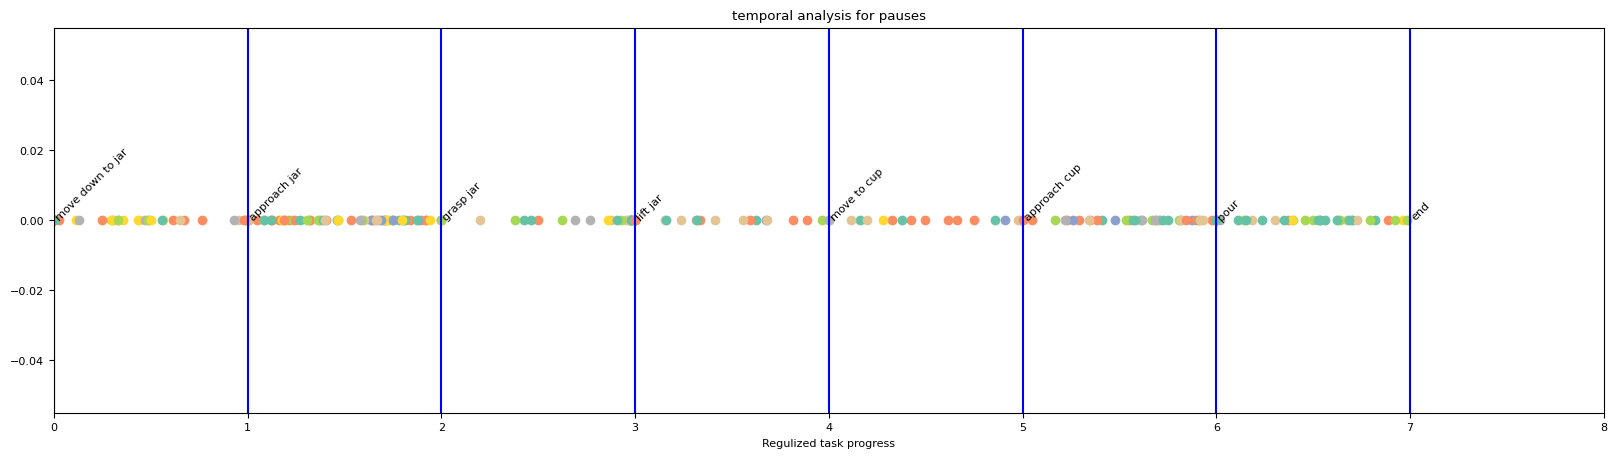

0.5098039215686274
0.3333333333333333


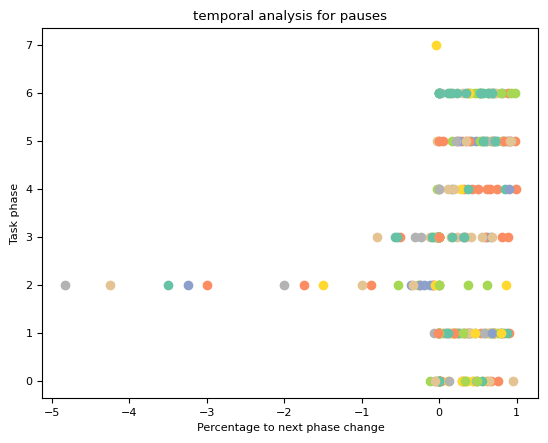

In [24]:
# plot all the pauses
# calculate percentage
pause_percentage_list,pause_phase_change_index, pause_phase_change_steps = calculate_percentage_to_phase_change(all_task_phase_change, pause_dict, eef_poses)
plot_percentage_with_phase(pause_percentage_list, pause_phase_change_index,plt_tilte="temporal analysis for pauses")
plot_percentage_to_phase_change(pause_percentage_list, pause_phase_change_index, plt_tiltle="temporal analysis for pauses")

In [25]:



alignment_dict = get_all_alignment_actions(annotation_data)
print(alignment_dict)
grasp_indicies = get_all_grasp_indicies(annotation_data)
print(grasp_indicies)


{'user_19': [[28, 36], [82, 91]], 'user_37': [[102, 153], [178, 194], [293, 461], [614, 640], [654, 740]], 'user_8': [[145, 172]], 'user_20': [[80, 92]], 'user_28': [[5, 10]], 'user_18': [[32, 36], [40, 49]], 'user_30': [], 'user_36': [[41, 57], [152, 179]], 'user_34': [[211, 241]], 'user_31': [[243, 316], [395, 416], [460, 500]], 'user_13': [[30, 70]], 'user_17': [[13, 24], [70, 78], [79, 99], [546, 557]], 'user_2': [], 'user_27': [[281, 296], [580, 712]], 'user_14': [[134, 156], [168, 175], [328, 336], [382, 393], [452, 460]], 'user_35': [], 'user_39': [[53, 57], [169, 192], [207, 227], [250, 271]], 'user_26': [[50, 65], [75, 96], [215, 295]], 'user_10': [[28, 55], [173, 183]], 'user_7': [[89, 114], [266, 282], [286, 293], [322, 333], [345, 394]], 'user_11': [[29, 62], [79, 98], [357, 369]], 'user_22': [], 'user_5': [[196, 211]], 'user_12': [[35, 50]], 'user_4': [[52, 66], [68, 80]], 'user_25': [[224, 251]], 'user_3': [[29, 37], [51, 62]], 'user_29': [[216, 240]], 'user_32': [[74, 86

In [26]:
def get_alignment_distances(alignment_actions_dict, grasp_indicies_dict, all_eef_poses, get_alignment_start=True):
    alignment_distances_grasp = dict()
    alignment_distances_cup = dict()
    relative_poses_cup = dict()
    relative_poses_grasp = dict()
    for user_id, alignment_actions_single in alignment_actions_dict.items():
        # get grasp eef_pose
        # print(grasp_indicies_dict[user_id])
        grasp_index = grasp_indicies_dict[user_id][0]
        grasp_eef_pose = all_eef_poses[user_id][grasp_index]
        cup_xy_pose = [0.33, -0.14]
        # calculate alignment actions poses relative to grasp pose and cup pose, choose the lesser one
        alignment_distances_single_grasp = []
        alignment_distances_single_cup = []
        relative_poses_single_cup = []
        relative_poses_single_grasp = []
        for alignment_action in alignment_actions_single:
            # print(alignment_action)
            if get_alignment_start:
                alignment_action_pose = all_eef_poses[user_id][alignment_action[0]]
            else:
                alignment_action_pose = all_eef_poses[user_id][alignment_action[1]]
            # print(alignment_action_pose)
            # print(grasp_eef_pose)
            alignment_action_pose_to_grasp = np.array(alignment_action_pose) - np.array(grasp_eef_pose)
            alignment_action_pose_to_cup = np.array(alignment_action_pose[:2]) - np.array(cup_xy_pose)  
            # choose the lesser one
            if np.linalg.norm(alignment_action_pose_to_grasp[:2]) < np.linalg.norm(alignment_action_pose_to_cup):
                alignment_distances_single_grasp.append(np.linalg.norm(alignment_action_pose_to_grasp, axis=-1))
                relative_poses_single_grasp.append(alignment_action_pose_to_grasp)
            else:
                alignment_distances_single_cup.append(np.linalg.norm(alignment_action_pose_to_cup, axis=-1))
                relative_poses_single_cup.append(alignment_action_pose_to_cup)
        alignment_distances_grasp[user_id] = alignment_distances_single_grasp
        alignment_distances_cup[user_id] = alignment_distances_single_cup
        relative_poses_grasp[user_id] = relative_poses_single_grasp
        relative_poses_cup[user_id] = relative_poses_single_cup
    return alignment_distances_grasp, alignment_distances_cup, relative_poses_grasp, relative_poses_cup

alignment_distances_grasp, alignment_distances_cup, rel_poses_grasp, rel_poses_cup = get_alignment_distances(alignment_dict, grasp_indicies, eef_poses)
print(rel_poses_cup['user_0'])
print(alignment_distances_cup['user_0'])

[array([ 0.05314501, -0.03651091]), array([ 0.07045704, -0.05218503])]
[0.06447820393916871, 0.0876782293779923]


In [27]:
# get average distance change before and after alignment
def get_average_distance_change(alignment_actions_dict, grasp_indicies_dict, all_eef_poses):
    alignment_distances_grasp, alignment_distances_cup, _, _ = get_alignment_distances(alignment_actions_dict, grasp_indicies_dict, all_eef_poses)
    alignment_distances_grasp_end, alignment_distances_cup_end, _, _ = get_alignment_distances(alignment_actions_dict, grasp_indicies_dict, all_eef_poses, get_alignment_start=False)
    distance_changes_list_grasp = []
    distance_changes_list_cup = []
    for user_id in alignment_distances_grasp.keys():
        if len(alignment_distances_grasp[user_id]) == 0:
            distance_changes_list_grasp.append(0)
            distance_changes_list_cup.append(0)
            continue
        if len(alignment_distances_cup[user_id]) == 0:
            distance_changes_list_grasp.append(0)
            distance_changes_list_cup.append(0)
            continue
        distance_changes_list_grasp.append(np.mean(np.array(alignment_distances_grasp_end[user_id]) - np.array(alignment_distances_grasp[user_id])))
        distance_changes_list_cup.append(np.mean(np.array(alignment_distances_cup_end[user_id]) - np.array(alignment_distances_cup[user_id])))
    return distance_changes_list_grasp, distance_changes_list_cup

distance_changes_grasp, distance_changes_cup = get_average_distance_change(alignment_dict, grasp_indicies, eef_poses)
print(distance_changes_grasp)
print(np.mean(distance_changes_grasp))
print(distance_changes_cup)
print(np.mean(distance_changes_cup))

[-0.07703702943641866, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -0.08689204076478056, 0, -0.0047629610786276, 0.00472857417150746, 0, 0.0021248067602439025, -0.005393727194281772, -0.005362449879841885, -0.05065829946822588, -0.04715850758372858, 0, 0, 0, 0, 0, 0, 0, -0.07819134877044498, 0, -0.12630969279788606, 0, 0, -0.01774635708877858, 0, 0, 0, 0, 0, 0]
-0.01231647582828158
[-0.006468637730835641, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.0002757789371073613, 0, -0.04570365189290833, 7.924400565599103e-05, 0, -0.029736203079882017, 0.02557985583246583, 0.00043322595965803595, 0.0009115411388874884, -0.00023934601627567664, 0, 0, 0, 0, 0, 0, 0, 0.009899319491625133, 0, 0.008491466653430396, 0, 0, 0.008237714650734793, 0, 0, 0, 0, 0, 0]
-0.000705992301258416


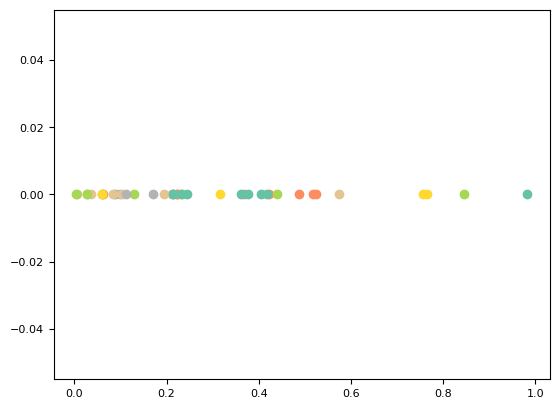

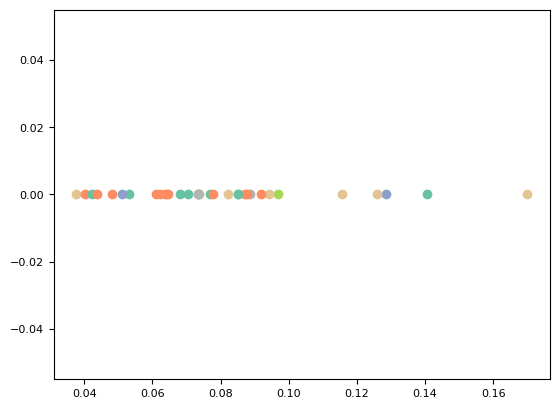

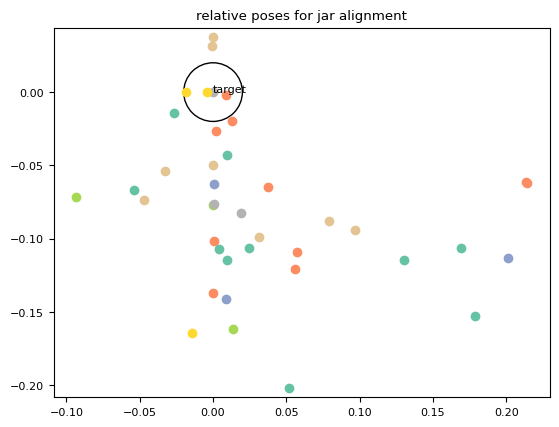

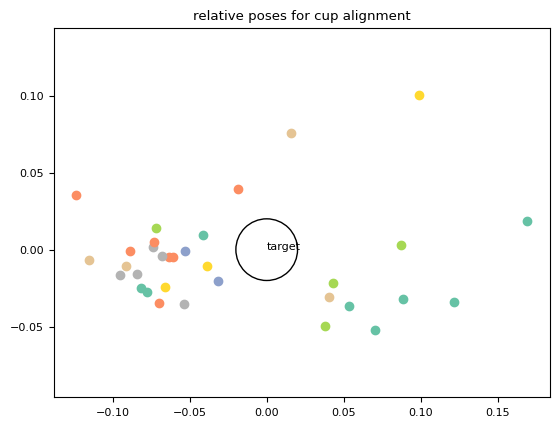

In [28]:
# plot the alignment distances
def plot_alignment_distances(alignment_distances):
    for user_id, alignment_distance in alignment_distances.items():
        plt.plot(alignment_distance,np.zeros_like(alignment_distance), 'o')
    plt.show()

def plot_relative_poses(relative_poses, plot_title="relative poses for jar alignment"):
    for user_id, relative_pose in relative_poses.items():
        if len(relative_pose) == 0:
            continue
        relative_pose = np.array(relative_pose)
        plt.plot(relative_pose[:,0], relative_pose[:,1], 'o')
    # set x and y axis to be equal
    plt.axis('equal')
    # plot a circle on the origin
    circle = plt.Circle((0,0),0.02,fill=False)
    plt.gca().add_artist(circle)
    # add label for the circle
    plt.text(0,0,"target")
    plt.title(plot_title)
    plt.show()

plot_alignment_distances(alignment_distances_grasp)
plot_alignment_distances(alignment_distances_cup)
plot_relative_poses(rel_poses_grasp)
plot_relative_poses(rel_poses_cup, plot_title="relative poses for cup alignment")

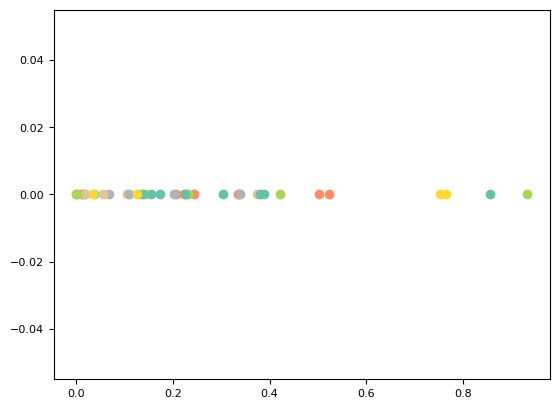

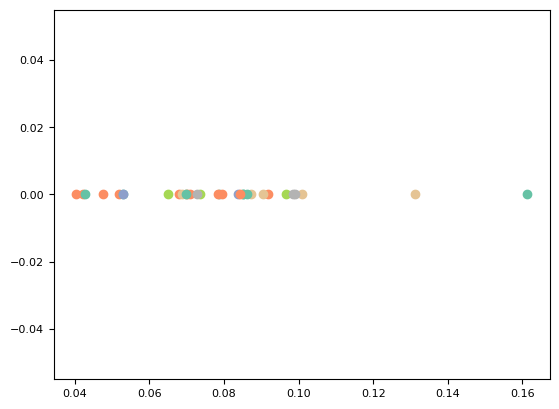

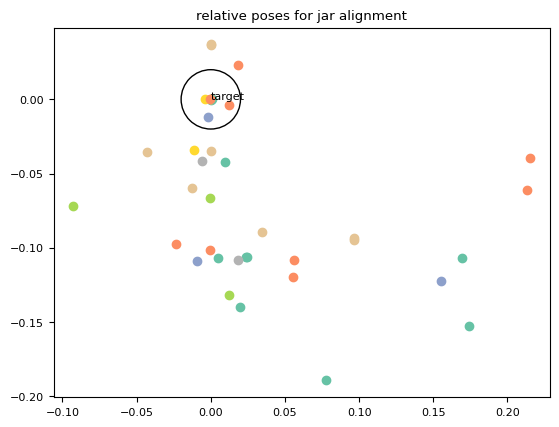

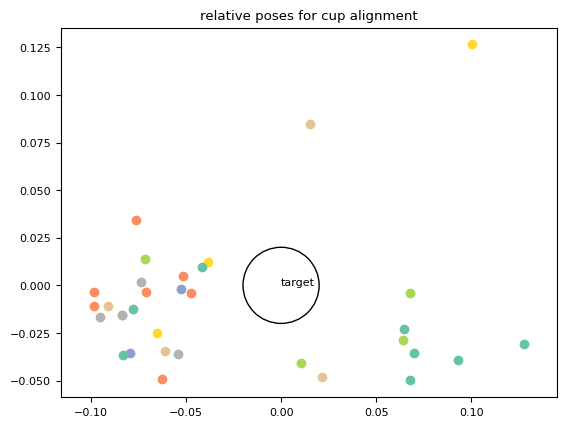

In [29]:
alignment_distances_grasp_end, alignment_distances_cup_end, rel_poses_grasp_end, rel_poses_cup_end = get_alignment_distances(alignment_dict, grasp_indicies, eef_poses, get_alignment_start=False)
plot_alignment_distances(alignment_distances_grasp_end)
plot_alignment_distances(alignment_distances_cup_end)
plot_relative_poses(rel_poses_grasp_end)
plot_relative_poses(rel_poses_cup_end, plot_title="relative poses for cup alignment")


<Figure size 1432x636.444 with 0 Axes>

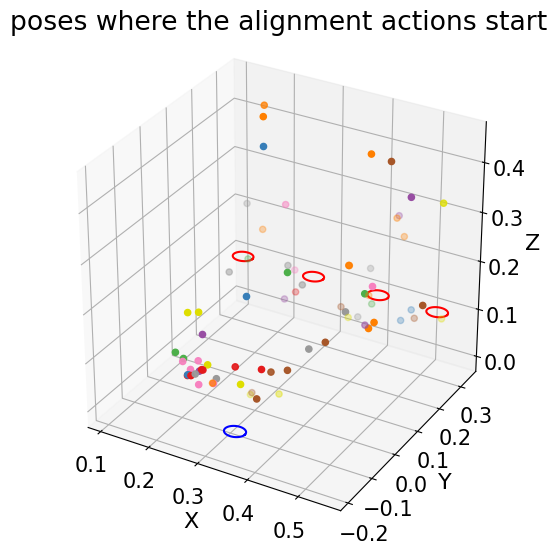

In [30]:
def plot_alignment_poses_position_3d(alignment_poses:dict, plot_titile = "poses where the alignment actions start"):
    CB_color_cycle = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']
# Set the font size to match IEEE standard
    plt.rcParams.update({'font.size': 16, 'axes.labelsize': 16, 'legend.fontsize': 16, 'xtick.labelsize': 16, 'ytick.labelsize': 16, 
                         'axes.prop_cycle': plt.cycler(color = CB_color_cycle)})

    # Width and height for a double-column figure in IEEE format
    fig_width = 7.16*2   # width in inches
    fig_height = (fig_width / 36) * 8 *2# height in inches to maintain 9:6 ratio for each subplot
    plt.figure(figsize=(fig_width, fig_height))
    color = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']
            # shuffle

    # SET FIGURE SIZE

    fig = plt.figure(figsize=(fig_width, fig_height))

    
    ax = fig.add_subplot(111, projection='3d')
    for user_id, alignment_pose in alignment_poses.items():
        if len(alignment_pose) == 0:
            continue
        alignment_pose = np.array(alignment_pose)
        ax.scatter(alignment_pose[:,0], alignment_pose[:,1], alignment_pose[:,2])
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    # set font size for ticks
    ax.tick_params(axis='both', which='major', labelsize=15)
    # make axis align
    ax.set_box_aspect([1,1,1])


    cup_xy_pose = [0.33, -0.14]
    radius = 0.02
    theta = np.linspace(0, 2*np.pi, 100)
    x_circle = radius * np.cos(theta) + cup_xy_pose[0]
    y_circle = radius * np.sin(theta) + cup_xy_pose[1]
    z_circle = np.zeros_like(x_circle)
    ax.plot(x_circle, y_circle, z_circle, c='b')

    jar_poses = [[0.53, 0.3, 0.11], [0.41, 0.3, 0.11], [0.276, 0.3, 0.11],[0.126, 0.3, 0.11]]
    jar_radius = 0.02
    # plot jar
    for jar_pose in jar_poses:
        x_circle = jar_radius * np.cos(theta) + jar_pose[0]
        y_circle = jar_radius * np.sin(theta) + jar_pose[1]
        z_circle = np.zeros_like(x_circle) + jar_pose[2]
        ax.plot(x_circle, y_circle, z_circle, c='r')

    plt.title(plot_titile)
    plt.show()

def get_alignment_positions(alignment_actions_dict, grasp_indicies_dict, all_eef_poses, get_alignment_start=True):
    alignment_distances_grasp = dict()
    alignment_distances_cup = dict()
    relative_poses_cup = dict()
    relative_poses_grasp = dict()
    absolute_poses = dict()
    for user_id, alignment_actions_single in alignment_actions_dict.items():
        # get grasp eef_pose
        # print(grasp_indicies_dict[user_id])
        grasp_index = grasp_indicies_dict[user_id][0]
        grasp_eef_pose = all_eef_poses[user_id][grasp_index]
        cup_xy_pose = [0.33, -0.14]
        # calculate alignment actions poses relative to grasp pose and cup pose, choose the lesser one
        alignment_distances_single_grasp = []
        alignment_distances_single_cup = []
        relative_poses_single_cup = []
        relative_poses_single_grasp = []
        absolute_poses_single = []
        for alignment_action in alignment_actions_single:
            # print(alignment_action)
            if get_alignment_start:
                alignment_action_pose = all_eef_poses[user_id][alignment_action[0]]
            else:
                alignment_action_pose = all_eef_poses[user_id][alignment_action[1]]
            # print(alignment_action_pose)
            # print(grasp_eef_pose)
            alignment_action_pose_to_grasp = np.array(alignment_action_pose) - np.array(grasp_eef_pose)
            alignment_action_pose_to_cup = np.array(alignment_action_pose[:2]) - np.array(cup_xy_pose)
            # print(alignment_action_pose)
            absolute_poses_single.append(alignment_action_pose[:3])
            # choose the lesser one
            if np.linalg.norm(alignment_action_pose_to_grasp[:2]) < np.linalg.norm(alignment_action_pose_to_cup):
                alignment_distances_single_grasp.append(np.linalg.norm(alignment_action_pose_to_grasp, axis=-1))
                relative_poses_single_grasp.append(alignment_action_pose_to_grasp)
            else:
                alignment_distances_single_cup.append(np.linalg.norm(alignment_action_pose_to_cup, axis=-1))
                relative_poses_single_cup.append(alignment_action_pose_to_cup)
        alignment_distances_grasp[user_id] = alignment_distances_single_grasp
        alignment_distances_cup[user_id] = alignment_distances_single_cup
        relative_poses_grasp[user_id] = relative_poses_single_grasp
        relative_poses_cup[user_id] = relative_poses_single_cup
        absolute_poses[user_id] = absolute_poses_single
    return alignment_distances_grasp, alignment_distances_cup, relative_poses_grasp, relative_poses_cup, absolute_poses


alignment_distances_grasp, alignment_distances_cup, rel_poses_grasp, rel_poses_cup, abs_poses = get_alignment_positions(alignment_dict, grasp_indicies, eef_poses)
plot_alignment_poses_position_3d(abs_poses)

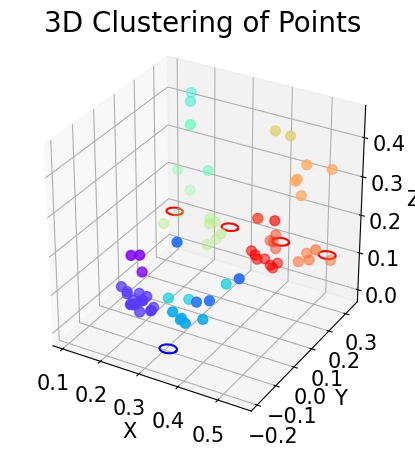

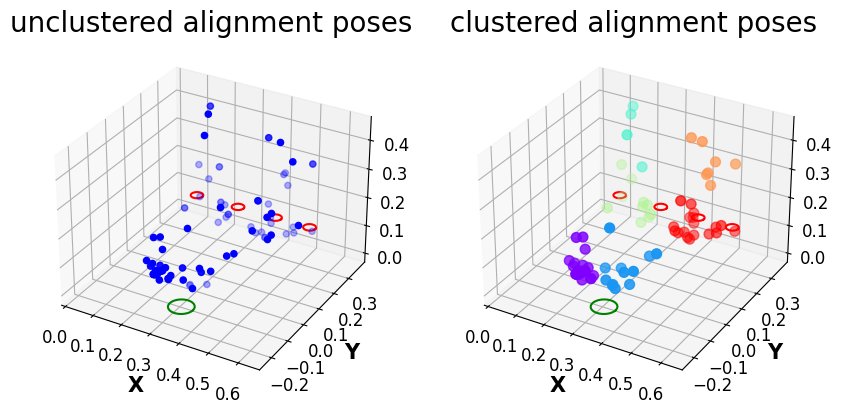

{'user_19': [array([0.49468833, 0.21283083, 0.12047108]), array([ 0.24869069, -0.1650698 ,  0.10302135])], 'user_37': [array([0.18537075, 0.27069412, 0.42753736]), array([0.15619163, 0.3335678 , 0.42014858]), array([0.16045095, 0.31599477, 0.17096174]), array([0.36074016, 0.27437357, 0.16915765]), array([0.36192962, 0.27400379, 0.16928541])], 'user_8': [array([ 0.20646211, -0.1044255 ,  0.09546571])], 'user_20': [array([ 0.29828637, -0.16040729,  0.10039681])], 'user_28': [array([0.4783011 , 0.18858844, 0.44729063])], 'user_18': [array([0.48585564, 0.21496791, 0.33046523]), array([0.50006351, 0.23480404, 0.36296325])], 'user_30': [], 'user_36': [array([0.40928871, 0.21111454, 0.10283442]), array([0.42286456, 0.12664712, 0.15445902])], 'user_34': [array([ 0.34590771, -0.06463104,  0.10024248])], 'user_31': [array([ 0.37285162, -0.16194006,  0.1007984 ]), array([ 0.41697919, -0.13684746,  0.10429821]), array([ 0.36753751, -0.18965962,  0.13265727])], 'user_13': [array([0.26315973, 0.1134

<Figure size 1432x636.444 with 0 Axes>

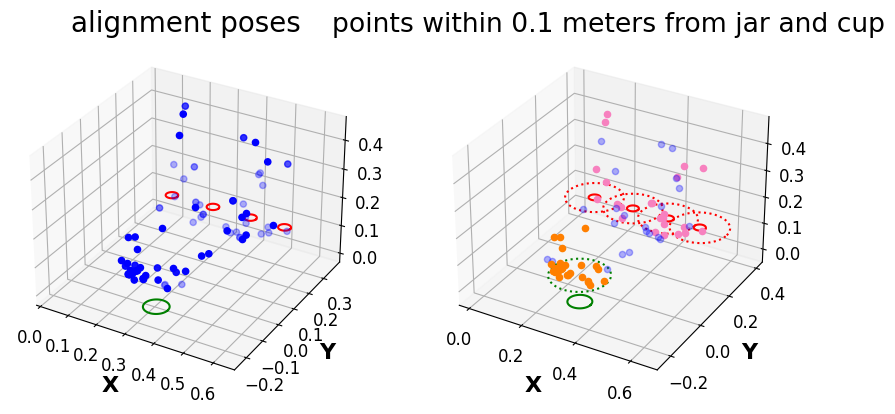

In [31]:
# do a cluster analysis on the alignment actions
abs_poses
import numpy as np

import matplotlib.pyplot as plt

from scipy.cluster.hierarchy import linkage, fcluster

from scipy.spatial.distance import pdist



def plot_alignment_poses_position_3d_with_cluster(alignment_poses:dict, plot_titile = "poses where the alignment actions start"):

    # make alignment poses into a list
    alignment_poses_list = []
    for user_id, alignment_pose in alignment_poses.items():
        if len(alignment_pose) == 0:
            continue
        alignment_poses_list.extend(alignment_pose)
    
    alignment_poses_list = np.array(alignment_poses_list)
    dist_matrix = pdist(alignment_poses_list)

    Z = linkage(dist_matrix, method='ward')



    # Form clusters based on a distance threshold

    threshold = 0.2  # This value can be adjusted

    clusters = fcluster(Z, threshold, criterion='distance')



    # Plot the points with color coding based on clusters

    fig = plt.figure(figsize=(10, 5))

    ax = fig.add_subplot(111, projection='3d', )

    scatter = ax.scatter(alignment_poses_list[:, 0], alignment_poses_list[:, 1], alignment_poses_list[:, 2], c=clusters, cmap='rainbow', s=50)

    ax.set_title('3D Clustering of Points', fontsize=20)
    ax.set_xlabel('X', fontsize=15)
    ax.set_ylabel('Y', fontsize=15)
    ax.set_zlabel('Z', fontsize=15)
    ax.tick_params(axis='both', which='major', labelsize=15)
    # Add legend for clusters
    # legend1 = ax.legend(*scatter.legend_elements(), title="Clusters")
    # ax.add_artist(legend1)
    ax.set_box_aspect([1,1,1])

    cup_xy_pose = [0.33, -0.14]
    radius = 0.02
    theta = np.linspace(0, 2*np.pi, 100)
    x_circle = radius * np.cos(theta) + cup_xy_pose[0]
    y_circle = radius * np.sin(theta) + cup_xy_pose[1]
    z_circle = np.zeros_like(x_circle)
    ax.plot(x_circle, y_circle, z_circle, c='b')

    jar_poses = [[0.53, 0.3, 0.11], [0.41, 0.3, 0.11], [0.276, 0.3, 0.11],[0.126, 0.3, 0.11]]
    jar_radius = 0.02
    # plot jar
    for jar_pose in jar_poses:
        x_circle = jar_radius * np.cos(theta) + jar_pose[0]
        y_circle = jar_radius * np.sin(theta) + jar_pose[1]
        z_circle = np.zeros_like(x_circle) + jar_pose[2]
        ax.plot(x_circle, y_circle, z_circle, c='r')
    plt.show()

plot_alignment_poses_position_3d_with_cluster(abs_poses)

# plot the unclustered and clustered alignment poses side by side
def side_by_side_cluster_and_unclustered(alignment_poses: dict):
    fig, axs = plt.subplots(1, 2, figsize=(10, 5), subplot_kw=dict(projection='3d'))

    # plot unclustered
    ax = axs[0]
    
    for user_id, alignment_pose in alignment_poses.items():
        if len(alignment_pose) == 0:
            continue
        alignment_pose = np.array(alignment_pose)
        ax.scatter(alignment_pose[:, 0], alignment_pose[:, 1], alignment_pose[:, 2], c='b')


    cup_xy_pose = [0.33, -0.14]
    radius = 0.04
    theta = np.linspace(0, 2*np.pi, 100)
    x_circle = radius * np.cos(theta) + cup_xy_pose[0]
    y_circle = radius * np.sin(theta) + cup_xy_pose[1]
    z_circle = np.zeros_like(x_circle)
    ax.plot(x_circle, y_circle, z_circle, c='g')

    jar_poses = [[0.53, 0.3, 0.11], [0.41, 0.3, 0.11], [0.276, 0.3, 0.11],[0.126, 0.3, 0.11]]
    jar_radius = 0.02
    # plot jar
    for jar_pose in jar_poses:
        x_circle = jar_radius * np.cos(theta) + jar_pose[0]
        y_circle = jar_radius * np.sin(theta) + jar_pose[1]
        z_circle = np.zeros_like(x_circle) + jar_pose[2]
        ax.plot(x_circle, y_circle, z_circle, c='r')
    
    ax.set_title('unclustered alignment poses', fontsize=20)
    # bold font for labels
    ax.set_xlabel('X', fontsize=15, fontweight='bold')
    ax.set_ylabel('Y', fontsize=15, fontweight='bold')
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.axis('equal')

    # plot clustered
    alignment_poses_list = []
    for user_id, alignment_pose in alignment_poses.items():
        if len(alignment_pose) == 0:
            continue
        alignment_poses_list.extend(alignment_pose)
    
    alignment_poses_list = np.array(alignment_poses_list)
    dist_matrix = pdist(alignment_poses_list)

    Z = linkage(dist_matrix, method='ward')

    threshold = 0.4  # This value can be adjusted

    clusters = fcluster(Z, threshold, criterion='distance')

    ax = axs[1]

    scatter = ax.scatter(alignment_poses_list[:, 0], alignment_poses_list[:, 1], alignment_poses_list[:,2], c=clusters, cmap='rainbow', s=50)
    x_circle = radius * np.cos(theta) + cup_xy_pose[0]
    y_circle = radius * np.sin(theta) + cup_xy_pose[1]
    z_circle = np.zeros_like(x_circle)
    ax.plot(x_circle, y_circle, z_circle, c='g')
    for jar_pose in jar_poses:
        x_circle = jar_radius * np.cos(theta) + jar_pose[0]
        y_circle = jar_radius * np.sin(theta) + jar_pose[1]
        z_circle = np.zeros_like(x_circle) + jar_pose[2]
        ax.plot(x_circle, y_circle, z_circle, c='r')
    ax.set_title('clustered alignment poses', fontsize=20)
    ax.set_xlabel('X', fontsize=15, fontweight='bold')
    ax.set_ylabel('Y', fontsize=15, fontweight='bold')
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.axis('equal')
    plt.show()
    

side_by_side_cluster_and_unclustered(abs_poses)


def plot_alignment_poses_with_circles_side_by_side(alignment_poses:dict, plot_titile = "poses where the alignment actions start"):

    CB_color_cycle = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']
# Set the font size to match IEEE standard
    plt.rcParams.update({'font.size': 16, 'axes.labelsize': 16, 'legend.fontsize': 16, 'xtick.labelsize': 16, 'ytick.labelsize': 16, 
                         'axes.prop_cycle': plt.cycler(color = CB_color_cycle)})

    # Width and height for a double-column figure in IEEE format
    fig_width = 7.16*2   # width in inches
    fig_height = (fig_width / 36) * 8 *2# height in inches to maintain 9:6 ratio for each subplot
    plt.figure(figsize=(fig_width, fig_height))
    color = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']
            # shuffle

    fig, axs = plt.subplots(1, 2, figsize=(10, 5), subplot_kw=dict(projection='3d'))
    
    points_near_jar = 0
    total_points = 0
    points_near_cup = 0
        # plot unclustered
    ax = axs[0]
    
    for user_id, alignment_pose in alignment_poses.items():
        if len(alignment_pose) == 0:
            continue
        print(alignment_pose)
        alignment_pose = np.array(alignment_pose)
        ax.scatter(alignment_pose[:, 0], alignment_pose[:, 1], alignment_pose[:, 2], c='b')


    cup_xy_pose = [0.33, -0.14]
    radius = 0.04
    theta = np.linspace(0, 2*np.pi, 100)
    x_circle = radius * np.cos(theta) + cup_xy_pose[0]
    y_circle = radius * np.sin(theta) + cup_xy_pose[1]
    z_circle = np.zeros_like(x_circle)
    ax.plot(x_circle, y_circle, z_circle, c='g')

    jar_poses = [[0.53, 0.3, 0.11], [0.41, 0.3, 0.11], [0.276, 0.3, 0.11],[0.126, 0.3, 0.11]]
    jar_radius = 0.02
    # plot jar
    for jar_pose in jar_poses:
        x_circle = jar_radius * np.cos(theta) + jar_pose[0]
        y_circle = jar_radius * np.sin(theta) + jar_pose[1]
        z_circle = np.zeros_like(x_circle) + jar_pose[2]
        ax.plot(x_circle, y_circle, z_circle, c='r')
    
    ax.set_title('alignment poses', fontsize=20)
    # bold font for labels
    ax.set_xlabel('X',  fontweight='bold')
    ax.set_ylabel('Y',  fontweight='bold')
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.axis('equal')

    ax = axs[1]
    jar_dist = 0.1
    cup_dist = 0.1
    for user_id, alignment_pose in alignment_poses.items():
        if len(alignment_pose) == 0:
            continue
        alignment_pose = np.array(alignment_pose)

        for single_pose in alignment_pose:
            is_close_to_jar = np.any([np.linalg.norm(single_pose[:2] - np.array(jar_pose)[:2] ) < jar_dist for jar_pose in jar_poses])
            is_close_to_cup = np.linalg.norm(single_pose[:2] - np.array(cup_xy_pose) ) < cup_dist

            if is_close_to_jar:
                ax.scatter(single_pose[0], single_pose[1], single_pose[2], c=color[3])
                points_near_jar += 1
            elif is_close_to_cup:
                ax.scatter(single_pose[0], single_pose[1], single_pose[2], c=color[1])
                points_near_cup += 1
            else:
                ax.scatter(single_pose[0], single_pose[1], single_pose[2], c='b', alpha=0.3)
            total_points += 1
        
    
    cup_xy_pose = [0.33, -0.14]
    radius = 0.04
    theta = np.linspace(0, 2*np.pi, 100)
    x_circle = radius * np.cos(theta) + cup_xy_pose[0]
    y_circle = radius * np.sin(theta) + cup_xy_pose[1]
    z_circle = np.zeros_like(x_circle)
    ax.plot(x_circle, y_circle, z_circle, c='g')

    jar_poses = [[0.53, 0.3, 0.11], [0.41, 0.3, 0.11], [0.276, 0.3, 0.11],[0.126, 0.3, 0.11]]
    jar_radius = 0.02
    # plot jar
    for jar_pose in jar_poses:
        x_circle = jar_radius * np.cos(theta) + jar_pose[0]
        y_circle = jar_radius * np.sin(theta) + jar_pose[1]
        z_circle = np.zeros_like(x_circle) + jar_pose[2]
        ax.plot(x_circle, y_circle, z_circle, c='r')
    
    # plot a dotted circle to show the distance
    x_circle = cup_dist * np.cos(theta) + cup_xy_pose[0]
    y_circle = cup_dist * np.sin(theta) + cup_xy_pose[1]
    z_circle = np.ones_like(x_circle)*0.1
    ax.plot(x_circle, y_circle, z_circle, c='g', linestyle='dotted')

    for jar_pose in jar_poses:
        x_circle = jar_dist * np.cos(theta) + jar_pose[0]
        y_circle = jar_dist * np.sin(theta) + jar_pose[1]
        z_circle = np.zeros_like(x_circle) + jar_pose[2]
        ax.plot(x_circle, y_circle, z_circle, c='r', linestyle='dotted')

    ax.set_title('points within 0.1 meters from jar and cup')
    # bold font for labels
    ax.set_xlabel('X',  fontweight='bold')
    ax.set_ylabel('Y', fontweight='bold')
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.axis('equal')

    print("near jar: ", points_near_jar / total_points)
    print("near cup: ", points_near_cup / total_points)

    plt.show()

print(abs_poses)
plot_alignment_poses_with_circles_side_by_side(abs_poses)



{'user_19': [array([0.49468833, 0.21283083, 0.12047108]), array([0.49905438, 0.22819782, 0.12020099]), array([0.51480514, 0.23817471, 0.11976795]), array([0.53160612, 0.24101676, 0.11907498]), array([0.53268242, 0.26379419, 0.12008859]), array([0.5295737 , 0.27204718, 0.12083725]), array([0.5326825 , 0.27206212, 0.12139155]), array([0.54626144, 0.27663453, 0.11851967]), array([ 0.24869069, -0.1650698 ,  0.10302135]), array([ 0.24732911, -0.16194411,  0.10319462]), array([ 0.24909187, -0.16041871,  0.10329974]), array([ 0.24946274, -0.15745491,  0.10305491]), array([ 0.25254173, -0.14675358,  0.10304083]), array([ 0.25255658, -0.14570987,  0.1029758 ]), array([ 0.2532554 , -0.14856462,  0.10379301]), array([ 0.2530206 , -0.15148149,  0.10338013]), array([ 0.25291839, -0.15187523,  0.10330832])], 'user_37': [array([0.18537075, 0.27069412, 0.42753736]), array([0.18143087, 0.27514318, 0.42629468]), array([0.17772046, 0.27823417, 0.42628636]), array([0.17675474, 0.27932406, 0.42592182]), ar

<Figure size 1432x636.444 with 0 Axes>

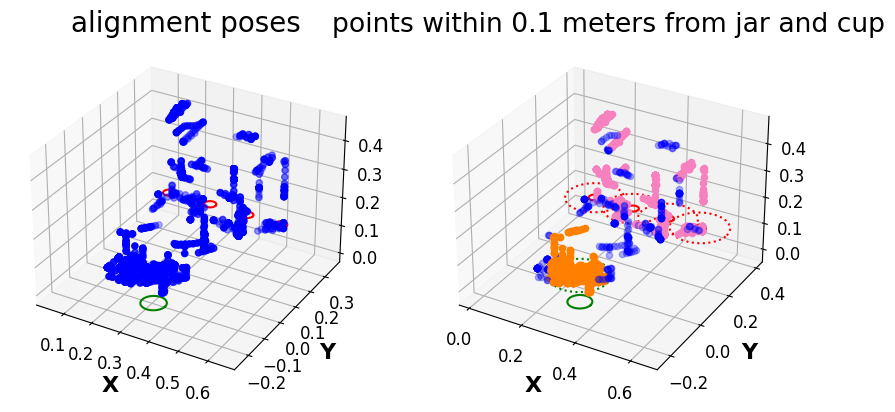

In [32]:
def get_alignment_positions_every_step(alignment_actions_dict, grasp_indicies_dict, all_eef_poses, get_alignment_start=True):
    alignment_distances_grasp = dict()
    alignment_distances_cup = dict()
    relative_poses_cup = dict()
    relative_poses_grasp = dict()
    absolute_poses = dict()
    for user_id, alignment_actions_single in alignment_actions_dict.items():
        # get grasp eef_pose
        # print(grasp_indicies_dict[user_id])
        grasp_index = grasp_indicies_dict[user_id][0]
        grasp_eef_pose = all_eef_poses[user_id][grasp_index]
        cup_xy_pose = [0.33, -0.14]
        # calculate alignment actions poses relative to grasp pose and cup pose, choose the lesser one
        alignment_distances_single_grasp = []
        alignment_distances_single_cup = []
        relative_poses_single_cup = []
        relative_poses_single_grasp = []
        absolute_poses_single = []
        for alignment_action in alignment_actions_single:
            alignment_action_pose = [eef_poses[user_id][idx][:3] for idx in range(alignment_action[0], alignment_action[1])]
            # print(alignment_action_pose)
            # print(grasp_eef_pose)
            # alignment_action_pose_to_grasp = np.array(alignment_action_pose) - np.array(grasp_eef_pose)
            # alignment_action_pose_to_cup = np.array(alignment_action_pose[:2]) - np.array(cup_xy_pose)
            # print(alignment_action_pose)
            absolute_poses_single.extend(alignment_action_pose)
            # choose the lesser one
            # if np.linalg.norm(alignment_action_pose_to_grasp[:2]) < np.linalg.norm(alignment_action_pose_to_cup):
            #     alignment_distances_single_grasp.append(np.linalg.norm(alignment_action_pose_to_grasp, axis=-1))
            #     relative_poses_single_grasp.append(alignment_action_pose_to_grasp)
            # else:
            #     pass
                # alignment_distances_single_cup.append(np.linalg.norm(alignment_action_pose_to_cup, axis=-1))
                # relative_poses_single_cup.append(alignment_action_pose_to_cup)
        # alignment_distances_grasp[user_id] = alignment_distances_single_grasp
        # alignment_distances_cup[user_id] = alignment_distances_single_cup
        relative_poses_grasp[user_id] = relative_poses_single_grasp
        relative_poses_cup[user_id] = relative_poses_single_cup
        absolute_poses[user_id] = absolute_poses_single
    # return alignment_distances_grasp, alignment_distances_cup, relative_poses_grasp, relative_poses_cup, absolute_poses
    return absolute_poses



# get_alignment_positions_every_step(alignment_dict, grasp_indicies, eef_poses)

absolute_poses_every_step = get_alignment_positions_every_step(alignment_dict, grasp_indicies, eef_poses)
print(absolute_poses_every_step)
plot_alignment_poses_with_circles_side_by_side(absolute_poses_every_step)


user id:  user_19
user id:  user_19
user id:  user_37
user id:  user_37
user id:  user_37
user id:  user_37
user id:  user_37
user id:  user_8
user id:  user_20
user id:  user_28
user id:  user_18
user id:  user_18
user id:  user_36
user id:  user_36
user id:  user_34
user id:  user_31
user id:  user_31
user id:  user_31
user id:  user_13
user id:  user_17
user id:  user_17
user id:  user_17
user id:  user_17
user id:  user_27
user id:  user_27
user id:  user_14
user id:  user_14
user id:  user_14
user id:  user_14
user id:  user_14
user id:  user_39
user id:  user_39
user id:  user_39
user id:  user_39
user id:  user_26
user id:  user_26
user id:  user_26
user id:  user_10
user id:  user_10
user id:  user_7
user id:  user_7
user id:  user_7
user id:  user_7
user id:  user_7
user id:  user_11
user id:  user_11
user id:  user_11
user id:  user_5
user id:  user_12
user id:  user_4
user id:  user_4
user id:  user_25
user id:  user_3
user id:  user_3
user id:  user_29
user id:  user_32
use

<Figure size 1432x636.444 with 0 Axes>

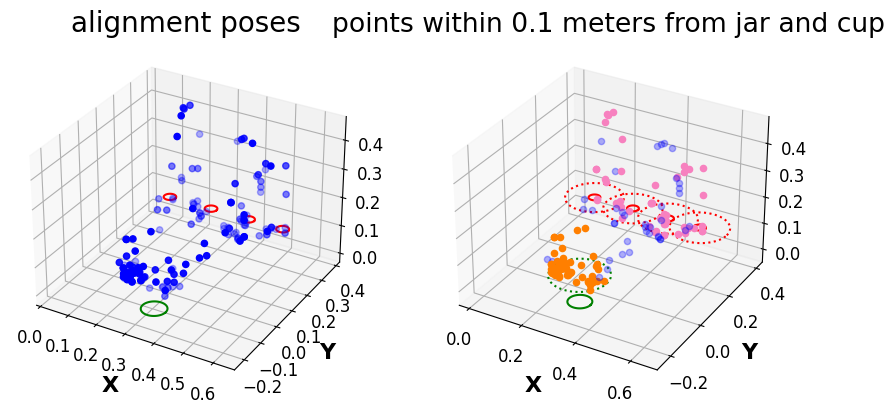

In [33]:
def get_alignment_positions_start_stop(alignment_actions_dict, grasp_indicies_dict, all_eef_poses, get_alignment_start=True):
    alignment_distances_grasp = dict()
    alignment_distances_cup = dict()
    relative_poses_cup = dict()
    relative_poses_grasp = dict()
    absolute_poses = dict()
    for user_id, alignment_actions_single in alignment_actions_dict.items():
        # get grasp eef_pose
        # print(grasp_indicies_dict[user_id])
        grasp_index = grasp_indicies_dict[user_id][0]
        grasp_eef_pose = all_eef_poses[user_id][grasp_index]
        cup_xy_pose = [0.33, -0.14]
        # calculate alignment actions poses relative to grasp pose and cup pose, choose the lesser one
        alignment_distances_single_grasp = []
        alignment_distances_single_cup = []
        relative_poses_single_cup = []
        relative_poses_single_grasp = []
        absolute_poses_single = []
        for alignment_action in alignment_actions_single:
            print("user id: ", user_id)
            alignment_action_pose = [eef_poses[user_id][alignment_action[0]], eef_poses[user_id][alignment_action[1]]]
            # print(alignment_action_pose)
            # print(grasp_eef_pose)
            # alignment_action_pose_to_grasp = np.array(alignment_action_pose) - np.array(grasp_eef_pose)
            # alignment_action_pose_to_cup = np.array(alignment_action_pose[:2]) - np.array(cup_xy_pose)
            # print(alignment_action_pose)
            absolute_poses_single.extend(alignment_action_pose)
            # choose the lesser one
            # if np.linalg.norm(alignment_action_pose_to_grasp[:2]) < np.linalg.norm(alignment_action_pose_to_cup):
            #     alignment_distances_single_grasp.append(np.linalg.norm(alignment_action_pose_to_grasp, axis=-1))
            #     relative_poses_single_grasp.append(alignment_action_pose_to_grasp)
            # else:
            #     pass
                # alignment_distances_single_cup.append(np.linalg.norm(alignment_action_pose_to_cup, axis=-1))
                # relative_poses_single_cup.append(alignment_action_pose_to_cup)
        # alignment_distances_grasp[user_id] = alignment_distances_single_grasp
        # alignment_distances_cup[user_id] = alignment_distances_single_cup
        relative_poses_grasp[user_id] = relative_poses_single_grasp
        relative_poses_cup[user_id] = relative_poses_single_cup
        absolute_poses[user_id] = absolute_poses_single
    # return alignment_distances_grasp, alignment_distances_cup, relative_poses_grasp, relative_poses_cup, absolute_poses
    return absolute_poses



# get_alignment_positions_every_step(alignment_dict, grasp_indicies, eef_poses)

absolute_poses_start_stop = get_alignment_positions_start_stop(alignment_dict, grasp_indicies, eef_poses)
print(absolute_poses_start_stop)
plot_alignment_poses_with_circles_side_by_side(absolute_poses_start_stop)


near jar:  0.3356164383561644
near cup:  0.3972602739726027


<Figure size 2864x2148 with 0 Axes>

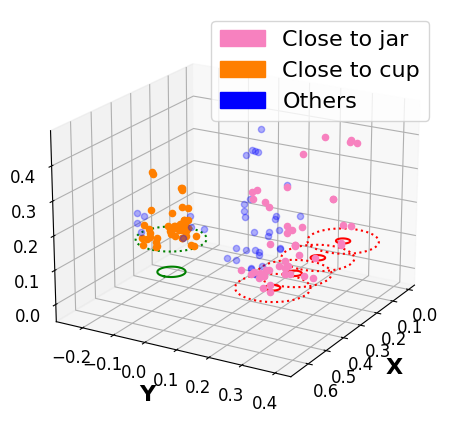

In [36]:
def plot_alignment_poses_with_circles_single(alignment_poses:dict, plot_titile = "poses where the alignment actions start"):

    CB_color_cycle = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']
# Set the font size to match IEEE standard
    plt.rcParams.update({'font.size': 16, 'axes.labelsize': 16, 'legend.fontsize': 16, 'xtick.labelsize': 16, 'ytick.labelsize': 16, 
                         'axes.prop_cycle': plt.cycler(color = CB_color_cycle)})

    # Width and height for a double-column figure in IEEE format
    fig_width = 7.16# width in inches
    fig_height = 3*fig_width / 4# height in inches to maintain 9:6 ratio for each subplot
    plt.figure(figsize=(fig_width, fig_height), dpi=400)
    color = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']
            # shuffle

    fig, axs = plt.subplots(1, 1, figsize=(fig_width, fig_height), subplot_kw=dict(projection='3d'))
    
    points_near_jar = 0
    total_points = 0
    points_near_cup = 0
        # plot unclustered
    # ax = axs[0]
    
    # for user_id, alignment_pose in alignment_poses.items():
    #     if len(alignment_pose) == 0:
    #         continue
    #     print(alignment_pose)
    #     alignment_pose = np.array(alignment_pose)
    #     ax.scatter(alignment_pose[:, 0], alignment_pose[:, 1], alignment_pose[:, 2], c='b')


    cup_xy_pose = [0.33, -0.14]
    radius = 0.04
    # theta = np.linspace(0, 2*np.pi, 100)
    # x_circle = radius * np.cos(theta) + cup_xy_pose[0]
    # y_circle = radius * np.sin(theta) + cup_xy_pose[1]
    # z_circle = np.zeros_like(x_circle)
    # ax.plot(x_circle, y_circle, z_circle, c='g')

    jar_poses = [[0.53, 0.3, 0.11], [0.41, 0.3, 0.11], [0.276, 0.3, 0.11],[0.126, 0.3, 0.11]]
    jar_radius = 0.02
    # # plot jar
    # for jar_pose in jar_poses:
    #     x_circle = jar_radius * np.cos(theta) + jar_pose[0]
    #     y_circle = jar_radius * np.sin(theta) + jar_pose[1]
    #     z_circle = np.zeros_like(x_circle) + jar_pose[2]
    #     ax.plot(x_circle, y_circle, z_circle, c='r')
    
    # ax.set_title('alignment poses', fontsize=20)
    # # bold font for labels
    # ax.set_xlabel('X',  fontweight='bold')
    # ax.set_ylabel('Y',  fontweight='bold')
    # ax.tick_params(axis='both', which='major', labelsize=12)
    # ax.axis('equal')

    ax = axs
    jar_dist = 0.1
    cup_dist = 0.1
    for user_id, alignment_pose in alignment_poses.items():
        if len(alignment_pose) == 0:
            continue
        alignment_pose = np.array(alignment_pose)

        for single_pose in alignment_pose:
            is_close_to_jar = np.any([np.linalg.norm(single_pose[:2] - np.array(jar_pose)[:2] ) < jar_dist for jar_pose in jar_poses])
            is_close_to_cup = np.linalg.norm(single_pose[:2] - np.array(cup_xy_pose) ) < cup_dist

            if is_close_to_jar:
                ax.scatter(single_pose[0], single_pose[1], single_pose[2], c=color[3])
                points_near_jar += 1
            elif is_close_to_cup:
                ax.scatter(single_pose[0], single_pose[1], single_pose[2], c=color[1])
                points_near_cup += 1
            else:
                ax.scatter(single_pose[0], single_pose[1], single_pose[2], c='b', alpha=0.3)
            total_points += 1
        
    
    cup_xy_pose = [0.33, -0.14]
    radius = 0.04
    theta = np.linspace(0, 2*np.pi, 100)
    x_circle = radius * np.cos(theta) + cup_xy_pose[0]
    y_circle = radius * np.sin(theta) + cup_xy_pose[1]
    z_circle = np.zeros_like(x_circle)
    ax.plot(x_circle, y_circle, z_circle, c='g')

    jar_poses = [[0.53, 0.3, 0.11], [0.41, 0.3, 0.11], [0.276, 0.3, 0.11],[0.126, 0.3, 0.11]]
    jar_radius = 0.02
    # plot jar
    for jar_pose in jar_poses:
        x_circle = jar_radius * np.cos(theta) + jar_pose[0]
        y_circle = jar_radius * np.sin(theta) + jar_pose[1]
        z_circle = np.zeros_like(x_circle) + jar_pose[2]
        ax.plot(x_circle, y_circle, z_circle, c='r')
    
    # plot a dotted circle to show the distance
    x_circle = cup_dist * np.cos(theta) + cup_xy_pose[0]
    y_circle = cup_dist * np.sin(theta) + cup_xy_pose[1]
    z_circle = np.ones_like(x_circle)*0.1
    ax.plot(x_circle, y_circle, z_circle, c='g', linestyle='dotted')

    for jar_pose in jar_poses:
        x_circle = jar_dist * np.cos(theta) + jar_pose[0]
        y_circle = jar_dist * np.sin(theta) + jar_pose[1]
        z_circle = np.zeros_like(x_circle) + jar_pose[2]
        ax.plot(x_circle, y_circle, z_circle, c='r', linestyle='dotted')

    # ax.set_title('Alignment within 0.1 meters from jar and cup')
    # bold font for labels
    ax.set_xlabel('X',  fontweight='bold')
    ax.set_ylabel('Y', fontweight='bold')
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.axis('equal')
    # 
    ax.view_init(elev=20, azim=30)
    print("near jar: ", points_near_jar / total_points)
    print("near cup: ", points_near_cup / total_points)
    # 

    jar_patch = mpatches.Patch(color=color[3], label='Close to jar')
    cup_patch = mpatches.Patch(color=color[1], label='Close to cup')
    other_patch = mpatches.Patch(color='b', label='Others')

    plt.legend(handles=[jar_patch, cup_patch, other_patch], loc='upper right', ncols=2)
    # false_actions_patch = mpatches.Patch(color=color[1], label='False actions')
    # alignment_actions_patch = mpatches.Patch(color=color[2], label='Alignment actions')
    # pauses_patch = mpatches.Patch(color=color[3], label='Pauses')
    plt.show()


plot_alignment_poses_with_circles_single(absolute_poses_start_stop)
